In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# ------------------------------------------ import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, CycleMotionDataGenerator
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model
from src.models.ModelUtils import load_pretrained_model

# ------------------------------------------path and project params
ARCHITECTURE = '3D' # 2D
DATASET = 'GCN'  # 'acdc' # or 'gcn' or different versions such as gcn_01/02
FOLD = 3 # CV fold 0-3
EXP_NAME = 'ax_sax/unetwithdownsamplingaugmentation_new_data' # Define an experiment name, could have subfolder conventions
EXPERIMENT = '{}/{}'.format(ARCHITECTURE, EXP_NAME) # Uniform path names, separation of concerns
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

# Our generator expects the following fix data structure (could be changed in src/data/Generators)
# any-path/
#    - AX_3D(anyname_img.nrrd and anyname_msk.nrrd)
#    - AX_to_SAX_3D
#    - SAX_3D
#    - SAX_to_AX_3D
DATA_PATH_AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to AX 3D files
DATA_PATH_AX2SAX = DATA_PATH_AX.replace('AX_3D', 'AX_to_SAX_3D') # path to ax2sax 3D files
DF_PATH = '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv' # path to folds dataframe

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# ------------------------------------------static model, loss and generator hyperparameters
DIM = [80, 112, 112] # network input params for spacing of 3, (z,y,x)
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
SPACING = [3, 3, 3] # if resample, resample to this spacing, (z,y,x)
M_POOL = [2, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # Not implemented for the AX2SAX case
SHUFFLE = True
AUGMENT_GRID = False # Not implemented for the AX2SAX case
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 10.0 # weighting factor of the ax2sax loss
WEIGHT_MSE_INPLANE = True # turn inplane weighting on/off
MASK_SMALLER_THAN_THRESHOLD = 0.001 # define the threshold for masking the ax2sax/sax2ax MSE loss, areas with smaller values, will be masked out

SAX_LOSS_WEIGHT = 10.0 # weighting factor of the sax2ax loss
CYCLE_LOSS = True # turn this loss on/off

FOCUS_LOSS_WEIGHT = 1.0 # weighting of the focus loss
FOCUS_LOSS = True # turn this loss on/off
USE_SAX2AX_PROB = False # apply the focus loss on SAX predictions, or on SAX2AX (back-transformed) predictions
MIN_UNET_PROBABILITY = 0.8 # threshold to count only prediction greater than this value for the focus loss

# ------------------------------------------individual training params
GENERATOR_WORKER = 2 # no of parallel workers in our generator. if not set, use batchsize, numbers greater than batchsize does not make any sense
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3spacing 3,3,3 use: 2
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose for upsampling
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# ------------------------------------------these metrics and loss function are meant if you continue training of the U-Net
metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]
LOSS_FUNCTION = metr.bce_dice_loss

# Create a logger instance with the following setup: info or debug to console and file and error logs to a separate file
# Define a config for param injection,
# save a serialized version to load the experiment for prediction/evaluation, 
# make sure all paths exist
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


2020-12-07 12:36:08,117 INFO -------------------- Start --------------------
2020-12-07 12:36:08,118 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-12-07 12:36:08,118 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data.log
2020-12-07 12:36:08,119 INFO Log level for console: INFO


['/gpu:0', '/gpu:1']
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'FOLD': 3, 'EXP_NAME': 'ax_sax/unetwithdownsamplingaugmentation_new_data', 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation_new_data', 'DATA_PATH_AX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/', 'DATA_PATH_AX2SAX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/', 'DF_PATH': '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv', 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36', 'DIM': [80, 112, 112], 'DEPTH': 4, 'FILTERS': 16, 'SPACING': [3, 3, 3], 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'IMG_CHANNELS': 1

# Check Tensorflow setup and available GPUs

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

2020-12-07 12:36:08,142 INFO Is built with tensorflow: True
2020-12-07 12:36:08,220 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2020-12-07 12:36:08,896 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10905300224874675564
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8765553060964596435
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17999640948056644406
physical_device_desc

# Load trainings and validation files for the choosen fold

In [3]:
# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH_AX,path_to_folds_df=DF_PATH, fold=FOLD)

logging.info('AX x_train files: {}, AX y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX x_val files: {}, AX y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes, they should be in the same directory but with a different suffix --> AX_to_SAX_3D
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

2020-12-07 12:36:09,110 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-07 12:36:09,110 INFO Patients train: 65
2020-12-07 12:36:09,116 INFO Selected 122 of 162 files with 65 of 86 patients for training fold 3
2020-12-07 12:36:09,116 INFO AX x_train files: 122, AX y_train files: 122
2020-12-07 12:36:09,117 INFO AX x_val files: 40, AX y_val files: 40
2020-12-07 12:36:09,121 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/
2020-12-07 12:36:09,122 INFO Patients train: 65
2020-12-07 12:36:09,127 INFO Selected 122 of 162 files with 65 of 86 patients for training fold 3
2020-12-07 12:36:09,129 INFO x_train files: 122, y_train files: 122
2020-12-07 12:36:09,130 INFO x_val files: 40, y_val files: 40


In [4]:
# filter files by name, debugging purpose
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

40
40
40


In [5]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

2020-12-07 12:36:09,849 INFO Create DataGenerator
2020-12-07 12:36:09,850 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 122 
 Augment_grid: False 
 Thread workers: 2
2020-12-07 12:36:09,852 INFO No augmentation
2020-12-07 12:36:09,853 INFO Create DataGenerator
2020-12-07 12:36:09,853 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 40 
 Augment_grid: False 
 Thread workers: 2
2020-12-07 12:36:09,854 INFO No augmentation


In [6]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=10, description='batch', max=20), Output()), _dom_classes=('widget-inter…

In [7]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

In [8]:
# load a pretrained 2D unet
"""
load past config for model training 
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
    
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # retrained with downsampling

# load config with all params into global namespace
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

2020-12-07 12:36:12,454 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-12-07 12:36:12,454 INFO load model with keras api
2020-12-07 12:36:14,820 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-12-07 12:36:14,821 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json .
2020-12-07 12:36:14,821 INFO loading model description
2020-12-07 12:36:15,687 INFO loading model weights
2020-12-07 12:36:15,859 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json loaded


In [9]:
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
# inject the pre-trained unet if given, otherwise build the model without the pretrained unet
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

2020-12-07 12:36:18,262 INFO unet given, use it to max probability
2020-12-07 12:36:36,886 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-07 12:36:36,887 INFO adding cycle loss with a weighting of 10.0
2020-12-07 12:36:36,887 INFO adding focus loss on mask_prob with a weighting of 1.0


In [10]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 80, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 5, 7, 7, 256), [(None, 8 3537424           input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d (GlobalAveragePooling3D (None, 256)

In [11]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.001', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()

    try:
        from tensorflow.keras.metrics import MSE as mse
        logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
        logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.001', description='mask_small…

In [12]:
# train one model
initial_epoch = 0
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    max_queue_size=20,
    workers=8,
    verbose=1)

2020-12-07 12:37:29,306 INFO Fit model, start trainings process


Epoch 1/200
61/61 [==============================] - ETA: 0s - loss: 21.3162 - ax2sax_loss: 1.1262 - sax2ax_loss: 0.9062 - mask_prob_loss: 0.9924
Epoch 00001: val_loss improved from inf to 20.35625, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/model.h5
61/61 [==============================] - 165s 3s/step - loss: 21.3162 - ax2sax_loss: 1.1262 - sax2ax_loss: 0.9062 - mask_prob_loss: 0.9924 - val_loss: 20.3563 - val_ax2sax_loss: 1.0965 - val_sax2ax_loss: 0.8399 - val_mask_prob_loss: 0.9923 - lr: 1.0000e-04
Epoch 2/200
61/61 [==============================] - ETA: 0s - loss: 20.8820 - ax2sax_loss: 1.0988 - sax2ax_loss: 0.8901 - mask_prob_loss: 0.9929
Epoch 00002: val_loss improved from 20.35625 to 20.01574, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/model.h5
61/61 [==============================] - 123s 2s/step - loss: 20.8820 - ax2sax_loss: 1.0988 - sax2ax_loss: 0.8901 - mask_prob_loss: 0.9929

In [ ]:
# if for any reason you want to save the latest model, use this cell
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [13]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' not in locals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/config.json' # Fold 0

# baseline ax1 sax1 focus1 inplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_11_00/config.json' # Fold 0

# baseline ax1 sax1 focus1 on_SAXpred  NOinplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0

#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/config.json' # Fold 0

# round the crop and pad values instead of ceil
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_18_20/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_22_02/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-04_16_56/config.json' # Fold 2
config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-07_12_36/config.json' # Fold 3


# load a pre-trained ax2sax model, create the graph and load the weights separately, due to own loss functions, this is easier
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-07 14:30:29,323 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation_new_data
2020-12-07 14:30:30,068 INFO unet given, use it to max probability
2020-12-07 14:30:48,204 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-07 14:30:48,205 INFO adding cycle loss with a weighting of 10.0
2020-12-07 14:30:48,206 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-07 14:30:48,484 INFO loaded model weights as h5 file


# Fast predictions with all files of the generator

In [10]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-03 20:07:27,707 INFO Create DataGenerator
2020-12-03 20:07:27,708 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 120 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 20:07:27,709 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [11]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-03 20:08:19,977 INFO Create DataGenerator
2020-12-03 20:08:19,977 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 20:08:19,978 INFO No augmentation


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [14]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [160,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=False)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-07 14:30:48,507 INFO Create DataGenerator
2020-12-07 14:30:48,507 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 40
 Scaler: MinMax
 Images: 40 
 Augment_grid: False 
 Thread workers: 2
2020-12-07 14:30:48,508 INFO No augmentation
2020-12-07 14:30:50,483 INFO Create DataGenerator
2020-12-07 14:30:50,484 INFO Datagenerator created with: 
 shape: [160, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 40
 Scaler: MinMax
 Images: 40 
 Augment_grid: False 
 Thread workers: 2
2020-12-07 14:30:50,485 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [15]:
#### 1st try to reconstruct the original physical size
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool enable the postprocessing such as connected component filtering
    :param use_mod: bool use the second transformation matrix/use_mod (which is optimized by the focus loss), or the first transformation
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to use multiple Unet models and combine their predictins on the AX2SAX volume
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    from src.data.Postprocess import undo_generator_steps
    from src.data.Dataset import get_reference_nrrd
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    if debug: logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()

    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    if debug: logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    if debug: logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n], prob[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    if debug: logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    if debug: logging.info('Repeat the transformation on the full resolution')
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    if debug: logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    if debug: logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        # handle sax predictions with higher priority
        # overwrite ax predictions where the sax model has predictions
        msk_ax[inv_msk==True] = inv_msk[inv_msk==True]
        inv_msk = msk_ax >=0.5
        #inv_msk = inv_msk >= 0.9
        #background_msk = np.logical_not(inv_msk)
        #msk_ax = msk_ax >=0.9

        #msk_comb = (inv_msk + msk_ax)[background_msk]
        #inv_msk[background_msk] = msk_comb
        #if debug: logging.info('additional ax pred at background according to sax pred on original AX image - before postprocessing')
        #if debug: show_2D_or_3D(ax_full_[::slice_n*3], background_msk[0][::slice_n*3])
        plt.show()
        if debug: logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    ax_full_ = ax_full_[...,0]
    #if debug: globals().update(locals())
    
    p = os.path.basename(full_file_name)
    
    reference_sitk = get_reference_nrrd(p, '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/')
    
    sitk_pred = undo_generator_steps(ndarray=inv_msk, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    sitk_ax_img = undo_generator_steps(ndarray=ax_full_,cfg=msk_cfg, interpol=sitk.sitkLinear, orig_sitk=reference_sitk)
    sitk_ax_msk = undo_generator_steps(ndarray=msk_gt_flatten, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    
    nda_ax = sitk.GetArrayFromImage(sitk_ax_img).astype(np.float32)
    nda_pred = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_pred)).astype(np.float32)
    nda_gt = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_ax_msk)).astype(np.float32)
    
    if debug: show_2D_or_3D(nda_ax,nda_pred)
    
    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(nda_pred.shape, nda_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(nda_gt, nda_pred).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(nda_gt, nda_pred).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(nda_gt, nda_pred).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    globals()['ax2sax'] = ax2sax_full.astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=19, description='im', max=39), IntSlider(value=5, description='slice_n',…

# This version was used for the TMI paper !!!

In [30]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save the predicted mask, the gt mask and the CMR image to a given experiment identifier for further evaluation and comparison

2020-12-07 14:35:22,346 INFO use modified translation to scale: True
2020-12-07 14:35:22,347 INFO 0000-0PTV75MP_2005-06-27_ED_msk.nrrd
2020-12-07 14:35:27,430 INFO DICE LV: 0.8981367349624634
2020-12-07 14:35:27,519 INFO DICE RV: 0.7475490570068359
2020-12-07 14:35:27,609 INFO DICE MYO: 0.526447594165802
2020-12-07 14:35:28,174 INFO Predicted mask rotated to AX on original AX image


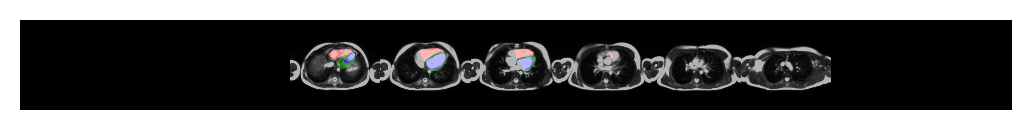

2020-12-07 14:35:28,611 INFO GT on AX


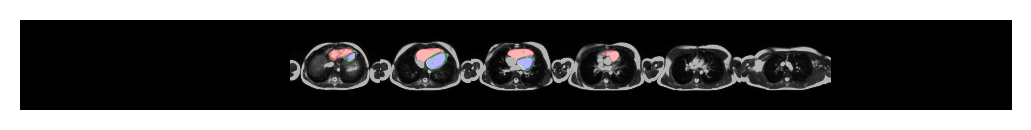

2020-12-07 14:35:29,173 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-07 14:35:29,179 INFO DICE LV: 0.9235582947731018
2020-12-07 14:35:29,184 INFO DICE RV: 0.7648956179618835
2020-12-07 14:35:29,189 INFO DICE MYO: 0.5553468465805054
2020-12-07 14:35:29,275 INFO m: [[ 4.543e-01 -6.699e-01 -5.869e-01 -9.995e-01]
 [ 3.315e-01 -4.846e-01  8.091e-01 -9.980e-01]
 [-8.271e-01 -5.625e-01  1.921e-03  1.677e+01]]
2020-12-07 14:35:29,276 INFO m_mod: [[ 0.4543   -0.67     -0.587    -0.758   ]
 [ 0.3315   -0.4846    0.809    -0.633   ]
 [-0.827    -0.5625    0.001921  1.388   ]]
2020-12-07 14:35:29,276 INFO m_scaled: [[ 4.543e-01 -6.699e-01 -5.869e-01 -1.516e+00]
 [ 3.315e-01 -4.846e-01  8.091e-01 -1.266e+00]
 [-8.271e-01 -5.625e-01  1.921e-03  2.775e+00]]
2020-12-07 14:35:29,278 INFO 0000-0PTV75MP_2005-06-27_ES_msk.nrrd
2020-12-07 14:35:34,340 INFO DICE LV: 0.8343378305435181
2020-12-07 14:35:34,439 INFO DICE RV: 0.718780517578125
2020-12-07 14:35:34,529 INFO DI

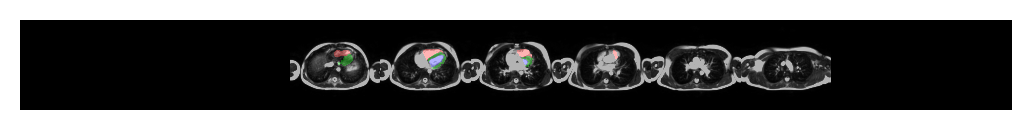

2020-12-07 14:35:35,534 INFO GT on AX


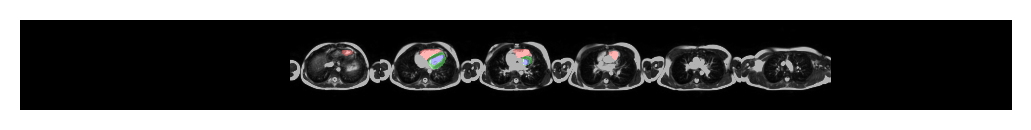

2020-12-07 14:35:36,088 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-07 14:35:36,093 INFO DICE LV: 0.8947567939758301
2020-12-07 14:35:36,097 INFO DICE RV: 0.7450436353683472
2020-12-07 14:35:36,102 INFO DICE MYO: 0.7136796116828918
2020-12-07 14:35:36,187 INFO m: [[ 4.543e-01 -6.689e-01 -5.889e-01 -9.995e-01]
 [ 3.318e-01 -4.868e-01  8.081e-01 -9.980e-01]
 [-8.271e-01 -5.625e-01  8.211e-04  1.680e+01]]
2020-12-07 14:35:36,187 INFO m_mod: [[ 4.543e-01 -6.689e-01 -5.889e-01 -7.588e-01]
 [ 3.318e-01 -4.868e-01  8.081e-01 -6.333e-01]
 [-8.271e-01 -5.625e-01  8.211e-04  1.390e+00]]
2020-12-07 14:35:36,188 INFO m_scaled: [[ 4.543e-01 -6.689e-01 -5.889e-01 -1.518e+00]
 [ 3.318e-01 -4.868e-01  8.081e-01 -1.267e+00]
 [-8.271e-01 -5.625e-01  8.211e-04  2.779e+00]]
2020-12-07 14:35:36,189 INFO 0000-0RPELLU8_2007-02-13_ED_msk.nrrd
2020-12-07 14:35:41,300 INFO DICE LV: 0.9266362190246582
2020-12-07 14:35:41,398 INFO DICE RV: 0.8249387145042419
2020-12-07 14:35:4

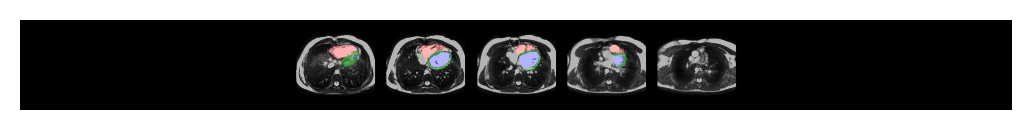

2020-12-07 14:35:42,529 INFO GT on AX


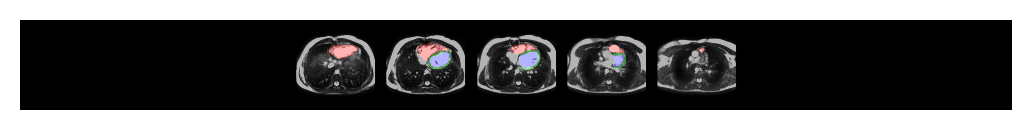

2020-12-07 14:35:43,023 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-07 14:35:43,030 INFO DICE LV: 0.9277358651161194
2020-12-07 14:35:43,036 INFO DICE RV: 0.8197051882743835
2020-12-07 14:35:43,043 INFO DICE MYO: 0.6571544408798218
2020-12-07 14:35:43,129 INFO m: [[ 4.570e-01 -6.855e-01 -5.669e-01 -9.995e-01]
 [ 3.296e-01 -4.612e-01  8.237e-01 -9.980e-01]
 [-8.262e-01 -5.630e-01  1.512e-02  1.652e+01]]
2020-12-07 14:35:43,130 INFO m_mod: [[ 0.457   -0.6855  -0.567   -0.7524 ]
 [ 0.3296  -0.4612   0.8237  -0.627  ]
 [-0.826   -0.563    0.01512  1.366  ]]
2020-12-07 14:35:43,130 INFO m_scaled: [[ 0.457   -0.6855  -0.567   -1.505  ]
 [ 0.3296  -0.4612   0.8237  -1.254  ]
 [-0.826   -0.563    0.01512  2.732  ]]
2020-12-07 14:35:43,131 INFO 0000-0RPELLU8_2007-02-13_ES_msk.nrrd
2020-12-07 14:35:48,214 INFO DICE LV: 0.7900379300117493
2020-12-07 14:35:48,308 INFO DICE RV: 0.6987994313240051
2020-12-07 14:35:48,395 INFO DICE MYO: 0.716519832611084
2020-12-0

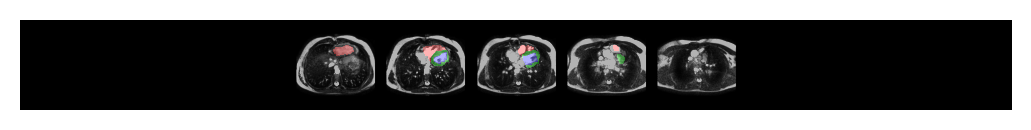

2020-12-07 14:35:49,398 INFO GT on AX


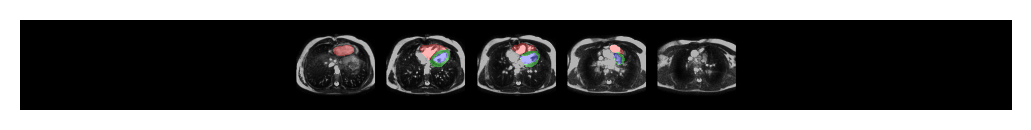

2020-12-07 14:35:49,886 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-07 14:35:49,893 INFO DICE LV: 0.806286096572876
2020-12-07 14:35:49,899 INFO DICE RV: 0.7697402238845825
2020-12-07 14:35:49,906 INFO DICE MYO: 0.7301965355873108
2020-12-07 14:35:49,990 INFO m: [[ 4.541e-01 -6.665e-01 -5.913e-01 -9.995e-01]
 [ 3.320e-01 -4.895e-01  8.066e-01 -9.980e-01]
 [-8.271e-01 -5.625e-01 -8.268e-04  1.681e+01]]
2020-12-07 14:35:49,990 INFO m_mod: [[ 4.541e-01 -6.665e-01 -5.913e-01 -7.588e-01]
 [ 3.320e-01 -4.895e-01  8.066e-01 -6.338e-01]
 [-8.271e-01 -5.625e-01 -8.268e-04  1.391e+00]]
2020-12-07 14:35:49,991 INFO m_scaled: [[ 4.541e-01 -6.665e-01 -5.913e-01 -1.518e+00]
 [ 3.320e-01 -4.895e-01  8.066e-01 -1.268e+00]
 [-8.271e-01 -5.625e-01 -8.268e-04  2.781e+00]]
2020-12-07 14:35:49,993 INFO 0000-2HQVK81W_2005-03-11_ED_msk.nrrd
2020-12-07 14:35:55,028 INFO DICE LV: 0.9019855260848999
2020-12-07 14:35:55,125 INFO DICE RV: 0.8642251491546631
2020-12-07 14:35:55

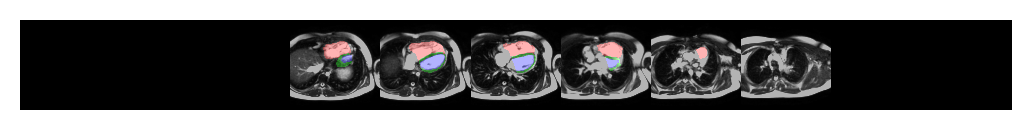

2020-12-07 14:35:56,215 INFO GT on AX


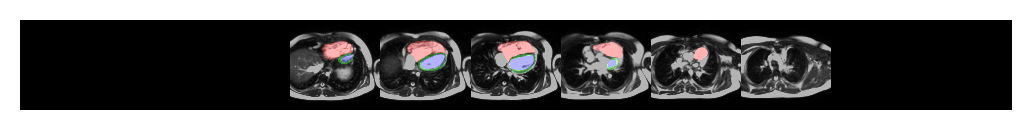

2020-12-07 14:35:56,779 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-07 14:35:56,785 INFO DICE LV: 0.9153960347175598
2020-12-07 14:35:56,791 INFO DICE RV: 0.8798394799232483
2020-12-07 14:35:56,796 INFO DICE MYO: 0.6935531497001648
2020-12-07 14:35:56,877 INFO m: [[ 0.4631  -0.7144  -0.5244  -0.9995 ]
 [ 0.3262  -0.4128   0.8506  -0.9976 ]
 [-0.824   -0.565    0.04172 15.984  ]]
2020-12-07 14:35:56,878 INFO m_mod: [[ 0.4631  -0.7144  -0.5244  -0.741  ]
 [ 0.3262  -0.4128   0.8506  -0.615  ]
 [-0.824   -0.565    0.04172  1.322  ]]
2020-12-07 14:35:56,878 INFO m_scaled: [[ 0.4631  -0.7144  -0.5244  -1.482  ]
 [ 0.3262  -0.4128   0.8506  -1.23   ]
 [-0.824   -0.565    0.04172  2.645  ]]
2020-12-07 14:35:56,879 INFO 0000-2HQVK81W_2005-03-11_ES_msk.nrrd
2020-12-07 14:36:01,866 INFO DICE LV: 0.7969836592674255
2020-12-07 14:36:01,961 INFO DICE RV: 0.7558578848838806
2020-12-07 14:36:02,056 INFO DICE MYO: 0.7486979365348816
2020-12-07 14:36:02,625 INFO Pre

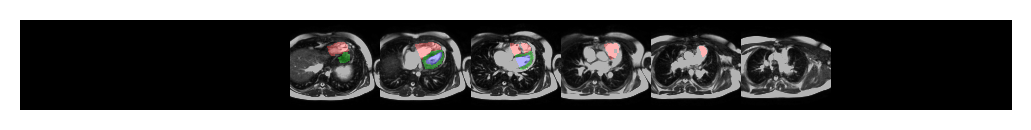

2020-12-07 14:36:03,056 INFO GT on AX


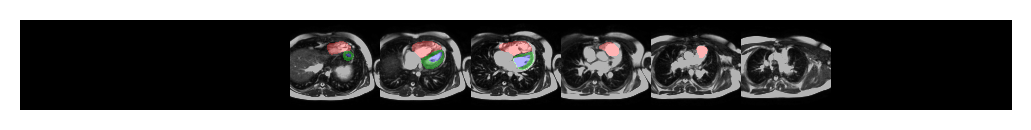

2020-12-07 14:36:03,612 INFO inv mask shape: (16, 256, 256, 4), gt mask shape: (16, 256, 256, 4)
2020-12-07 14:36:03,618 INFO DICE LV: 0.8226388692855835
2020-12-07 14:36:03,622 INFO DICE RV: 0.7958999872207642
2020-12-07 14:36:03,628 INFO DICE MYO: 0.7625220417976379
2020-12-07 14:36:03,710 INFO m: [[ 0.4631  -0.7144  -0.5244  -0.9995 ]
 [ 0.3262  -0.4128   0.8506  -0.9976 ]
 [-0.824   -0.565    0.04172 15.984  ]]
2020-12-07 14:36:03,710 INFO m_mod: [[ 0.4631  -0.7144  -0.5244  -0.741  ]
 [ 0.3262  -0.4128   0.8506  -0.615  ]
 [-0.824   -0.565    0.04172  1.322  ]]
2020-12-07 14:36:03,711 INFO m_scaled: [[ 0.4631  -0.7144  -0.5244  -1.482  ]
 [ 0.3262  -0.4128   0.8506  -1.23   ]
 [-0.824   -0.565    0.04172  2.645  ]]
2020-12-07 14:36:03,712 INFO 0000-3E8U83K5_2006-04-01_ED_msk.nrrd
2020-12-07 14:36:08,759 INFO DICE LV: 0.8745608925819397
2020-12-07 14:36:08,854 INFO DICE RV: 0.712184488773346
2020-12-07 14:36:08,948 INFO DICE MYO: 0.6871120929718018
2020-12-07 14:36:09,520 INFO Pred

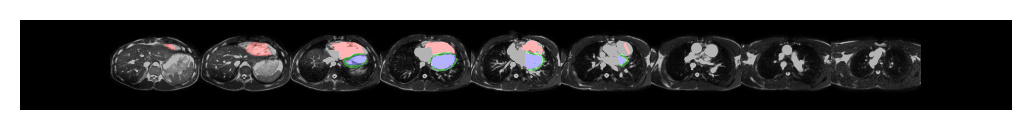

2020-12-07 14:36:09,969 INFO GT on AX


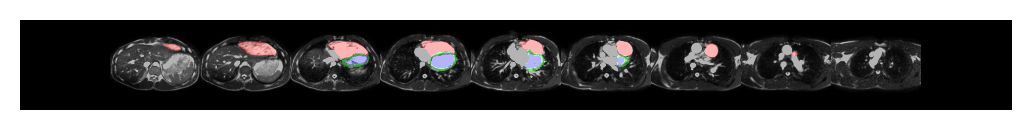

2020-12-07 14:36:10,638 INFO inv mask shape: (36, 256, 256, 4), gt mask shape: (36, 256, 256, 4)
2020-12-07 14:36:10,648 INFO DICE LV: 0.8572750091552734
2020-12-07 14:36:10,657 INFO DICE RV: 0.721198558807373
2020-12-07 14:36:10,666 INFO DICE MYO: 0.6758610010147095
2020-12-07 14:36:10,749 INFO m: [[ 4.548e-01 -6.738e-01 -5.820e-01 -9.995e-01]
 [ 3.311e-01 -4.790e-01  8.130e-01 -9.980e-01]
 [-8.267e-01 -5.625e-01  5.215e-03  1.669e+01]]
2020-12-07 14:36:10,750 INFO m_mod: [[ 0.4548   -0.674    -0.582    -0.756   ]
 [ 0.331    -0.479     0.813    -0.631   ]
 [-0.8267   -0.5625    0.005215  1.379   ]]
2020-12-07 14:36:10,750 INFO m_scaled: [[ 0.4548   -0.674    -0.582    -1.512   ]
 [ 0.331    -0.479     0.813    -1.262   ]
 [-0.8267   -0.5625    0.005215  2.758   ]]
2020-12-07 14:36:10,752 INFO 0000-3E8U83K5_2006-04-01_ES_msk.nrrd
2020-12-07 14:36:15,785 INFO DICE LV: 0.8619776368141174
2020-12-07 14:36:15,881 INFO DICE RV: 0.5779761672019958
2020-12-07 14:36:15,977 INFO DICE MYO: 0.76

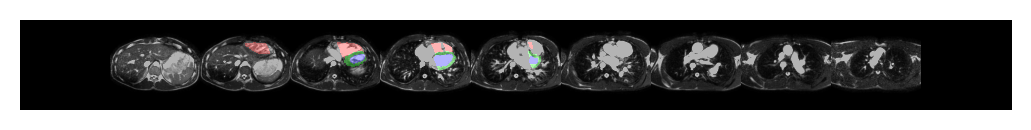

2020-12-07 14:36:16,969 INFO GT on AX


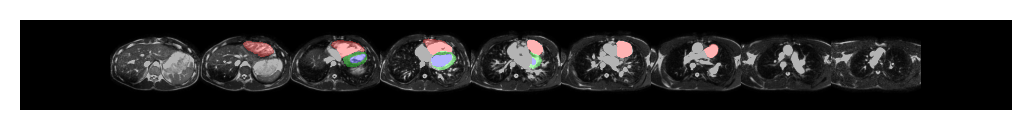

2020-12-07 14:36:17,641 INFO inv mask shape: (36, 256, 256, 4), gt mask shape: (36, 256, 256, 4)
2020-12-07 14:36:17,651 INFO DICE LV: 0.8775581121444702
2020-12-07 14:36:17,659 INFO DICE RV: 0.5772061944007874
2020-12-07 14:36:17,668 INFO DICE MYO: 0.7765851020812988
2020-12-07 14:36:17,752 INFO m: [[ 4.556e-01 -6.758e-01 -5.796e-01 -9.995e-01]
 [ 3.311e-01 -4.758e-01  8.149e-01 -9.980e-01]
 [-8.262e-01 -5.630e-01  6.866e-03  1.666e+01]]
2020-12-07 14:36:17,753 INFO m_mod: [[ 0.4556   -0.676    -0.5796   -0.7554  ]
 [ 0.331    -0.4758    0.815    -0.63    ]
 [-0.826    -0.563     0.006866  1.377   ]]
2020-12-07 14:36:17,753 INFO m_scaled: [[ 0.4556   -0.676    -0.5796   -1.511   ]
 [ 0.331    -0.4758    0.815    -1.26    ]
 [-0.826    -0.563     0.006866  2.754   ]]
2020-12-07 14:36:17,754 INFO 0000-3E90836W_2006-05-23_ED_msk.nrrd
2020-12-07 14:36:22,792 INFO DICE LV: 0.703498899936676
2020-12-07 14:36:22,888 INFO DICE RV: 0.674470067024231
2020-12-07 14:36:22,978 INFO DICE MYO: 0.469

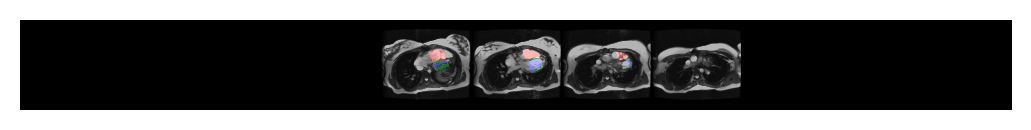

2020-12-07 14:36:23,975 INFO GT on AX


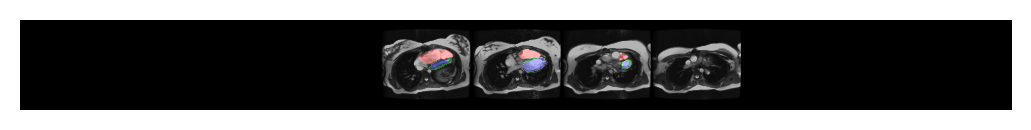

2020-12-07 14:36:24,570 INFO inv mask shape: (17, 512, 512, 4), gt mask shape: (17, 512, 512, 4)
2020-12-07 14:36:24,586 INFO DICE LV: 0.6998760104179382
2020-12-07 14:36:24,601 INFO DICE RV: 0.6885785460472107
2020-12-07 14:36:24,617 INFO DICE MYO: 0.47588565945625305
2020-12-07 14:36:24,701 INFO m: [[ 0.445   -0.6123  -0.654   -0.9995 ]
 [ 0.3376  -0.562    0.756   -0.9985 ]
 [-0.8296  -0.557   -0.04333 17.64   ]]
2020-12-07 14:36:24,702 INFO m_mod: [[ 0.445   -0.6123  -0.654   -0.7754 ]
 [ 0.3376  -0.562    0.756   -0.6514 ]
 [-0.8296  -0.557   -0.04333  1.46   ]]
2020-12-07 14:36:24,702 INFO m_scaled: [[ 0.445   -0.6123  -0.654   -1.551  ]
 [ 0.3376  -0.562    0.756   -1.303  ]
 [-0.8296  -0.557   -0.04333  2.92   ]]
2020-12-07 14:36:24,706 INFO 0000-3E90836W_2006-05-23_ES_msk.nrrd
2020-12-07 14:36:29,756 INFO DICE LV: 0.5866603255271912
2020-12-07 14:36:29,851 INFO DICE RV: 0.598602294921875
2020-12-07 14:36:29,946 INFO DICE MYO: 0.5738999843597412
2020-12-07 14:36:30,508 INFO Pre

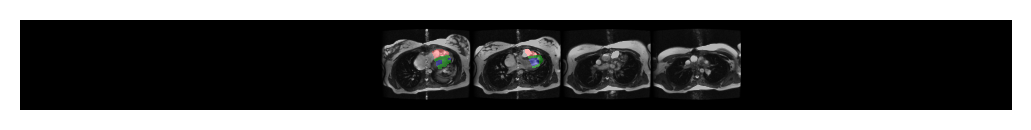

2020-12-07 14:36:30,946 INFO GT on AX


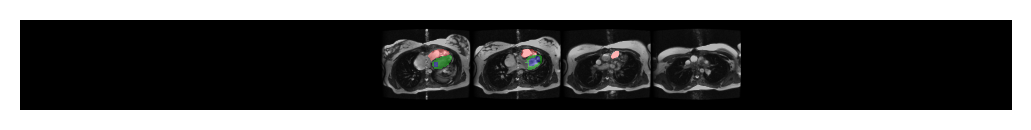

2020-12-07 14:36:31,539 INFO inv mask shape: (17, 512, 512, 4), gt mask shape: (17, 512, 512, 4)
2020-12-07 14:36:31,555 INFO DICE LV: 0.6447722315788269
2020-12-07 14:36:31,570 INFO DICE RV: 0.6364268064498901
2020-12-07 14:36:31,585 INFO DICE MYO: 0.6224992871284485
2020-12-07 14:36:31,669 INFO m: [[ 0.446  -0.6167 -0.649  -0.9995]
 [ 0.3372 -0.556   0.7603 -0.9985]
 [-0.829  -0.5576 -0.0401 17.58  ]]
2020-12-07 14:36:31,669 INFO m_mod: [[ 0.446  -0.6167 -0.649  -0.774 ]
 [ 0.3372 -0.556   0.7603 -0.65  ]
 [-0.829  -0.5576 -0.0401  1.454 ]]
2020-12-07 14:36:31,670 INFO m_scaled: [[ 0.446  -0.6167 -0.649  -1.548 ]
 [ 0.3372 -0.556   0.7603 -1.3   ]
 [-0.829  -0.5576 -0.0401  2.908 ]]
2020-12-07 14:36:31,673 INFO 0000-3HQQHA3N_2006-03-01_ED_msk.nrrd
2020-12-07 14:36:36,698 INFO DICE LV: 0.8401941061019897
2020-12-07 14:36:36,793 INFO DICE RV: 0.642107367515564
2020-12-07 14:36:36,888 INFO DICE MYO: 0.6357059478759766
2020-12-07 14:36:37,459 INFO Predicted mask rotated to AX on original

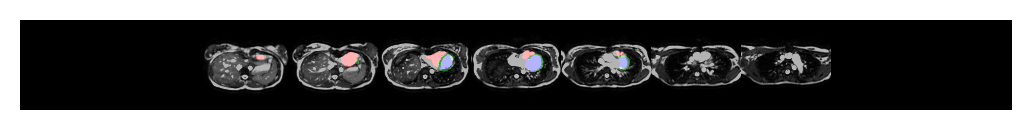

2020-12-07 14:36:37,900 INFO GT on AX


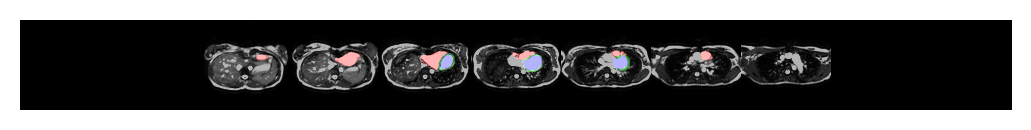

2020-12-07 14:36:38,467 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:36:38,475 INFO DICE LV: 0.8524718880653381
2020-12-07 14:36:38,482 INFO DICE RV: 0.6794023513793945
2020-12-07 14:36:38,490 INFO DICE MYO: 0.6291427612304688
2020-12-07 14:36:38,573 INFO m: [[ 4.548e-01 -6.729e-01 -5.840e-01 -9.995e-01]
 [ 3.313e-01 -4.810e-01  8.120e-01 -9.980e-01]
 [-8.267e-01 -5.625e-01  4.116e-03  1.672e+01]]
2020-12-07 14:36:38,574 INFO m_mod: [[ 0.4548   -0.673    -0.584    -0.757   ]
 [ 0.3313   -0.481     0.812    -0.632   ]
 [-0.8267   -0.5625    0.004116  1.383   ]]
2020-12-07 14:36:38,574 INFO m_scaled: [[ 0.4548   -0.673    -0.584    -1.514   ]
 [ 0.3313   -0.481     0.812    -1.264   ]
 [-0.8267   -0.5625    0.004116  2.766   ]]
2020-12-07 14:36:38,575 INFO 0000-3HQQHA3N_2006-03-01_ES_msk.nrrd
2020-12-07 14:36:46,159 INFO DICE LV: 0.8469806909561157
2020-12-07 14:36:46,231 INFO DICE RV: 0.6117831468582153
2020-12-07 14:36:46,304 INFO DICE MYO: 0.7

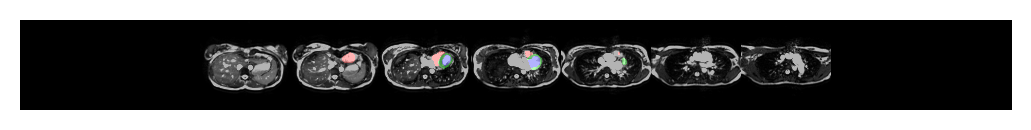

2020-12-07 14:36:47,268 INFO GT on AX


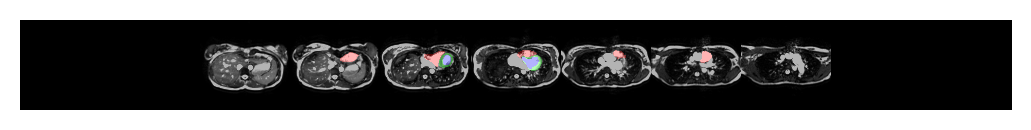

2020-12-07 14:36:47,763 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:36:47,771 INFO DICE LV: 0.8535612225532532
2020-12-07 14:36:47,779 INFO DICE RV: 0.622156023979187
2020-12-07 14:36:47,787 INFO DICE MYO: 0.7105123400688171
2020-12-07 14:36:47,857 INFO m: [[ 4.546e-01 -6.719e-01 -5.845e-01 -9.995e-01]
 [ 3.313e-01 -4.817e-01  8.110e-01 -9.980e-01]
 [-8.267e-01 -5.625e-01  3.569e-03  1.672e+01]]
2020-12-07 14:36:47,858 INFO m_mod: [[ 0.4546   -0.672    -0.5845   -0.757   ]
 [ 0.3313   -0.4817    0.811    -0.632   ]
 [-0.8267   -0.5625    0.003569  1.383   ]]
2020-12-07 14:36:47,858 INFO m_scaled: [[ 0.4546   -0.672    -0.5845   -1.514   ]
 [ 0.3313   -0.4817    0.811    -1.264   ]
 [-0.8267   -0.5625    0.003569  2.766   ]]
2020-12-07 14:36:47,859 INFO 0000-4EUFPCDM_2007-01-15_ED_msk.nrrd
2020-12-07 14:36:52,956 INFO DICE LV: 0.879680335521698
2020-12-07 14:36:53,031 INFO DICE RV: 0.7521803379058838
2020-12-07 14:36:53,104 INFO DICE MYO: 0.559

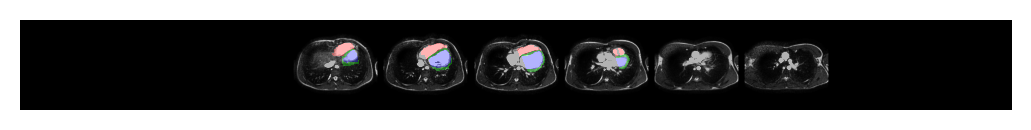

2020-12-07 14:36:54,079 INFO GT on AX


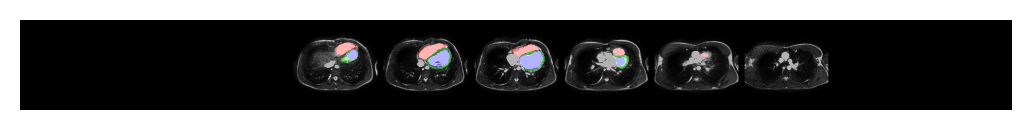

2020-12-07 14:36:54,567 INFO inv mask shape: (16, 288, 288, 4), gt mask shape: (16, 288, 288, 4)
2020-12-07 14:36:54,573 INFO DICE LV: 0.8892697095870972
2020-12-07 14:36:54,579 INFO DICE RV: 0.7843086123466492
2020-12-07 14:36:54,584 INFO DICE MYO: 0.5785083770751953
2020-12-07 14:36:54,653 INFO m: [[ 0.4492  -0.6416  -0.6216  -0.9995 ]
 [ 0.3342  -0.524    0.783   -0.9985 ]
 [-0.828   -0.5596  -0.02106 17.22   ]]
2020-12-07 14:36:54,653 INFO m_mod: [[ 0.4492  -0.6416  -0.6216  -0.7666 ]
 [ 0.3342  -0.524    0.783   -0.642  ]
 [-0.828   -0.5596  -0.02106  1.424  ]]
2020-12-07 14:36:54,654 INFO m_scaled: [[ 0.4492  -0.6416  -0.6216  -1.533  ]
 [ 0.3342  -0.524    0.783   -1.284  ]
 [-0.828   -0.5596  -0.02106  2.848  ]]
2020-12-07 14:36:54,655 INFO 0000-4EUFPCDM_2007-01-15_ES_msk.nrrd
2020-12-07 14:37:00,733 INFO DICE LV: 0.8222918510437012
2020-12-07 14:37:00,806 INFO DICE RV: 0.6514742374420166
2020-12-07 14:37:00,878 INFO DICE MYO: 0.6077079176902771
2020-12-07 14:37:01,421 INFO Pre

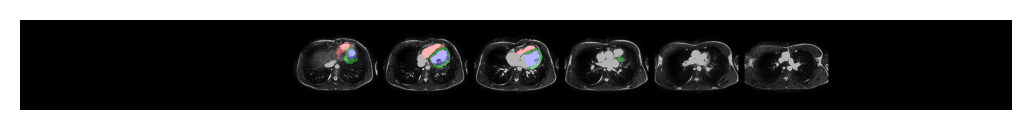

2020-12-07 14:37:01,858 INFO GT on AX


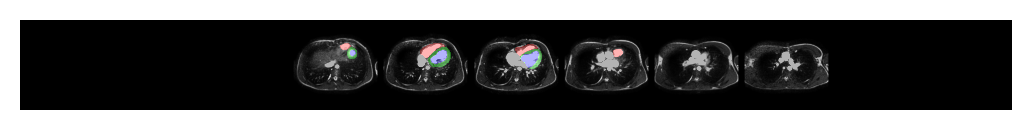

2020-12-07 14:37:02,345 INFO inv mask shape: (16, 288, 288, 4), gt mask shape: (16, 288, 288, 4)
2020-12-07 14:37:02,351 INFO DICE LV: 0.8340595960617065
2020-12-07 14:37:02,357 INFO DICE RV: 0.6897692084312439
2020-12-07 14:37:02,363 INFO DICE MYO: 0.6102848649024963
2020-12-07 14:37:02,431 INFO m: [[ 0.4485  -0.6343  -0.6294  -0.9995 ]
 [ 0.3352  -0.533    0.7764  -0.9985 ]
 [-0.8286  -0.5596  -0.02652 17.33   ]]
2020-12-07 14:37:02,432 INFO m_mod: [[ 0.4485  -0.6343  -0.6294  -0.769  ]
 [ 0.3352  -0.533    0.7764  -0.6445 ]
 [-0.8286  -0.5596  -0.02652  1.433  ]]
2020-12-07 14:37:02,432 INFO m_scaled: [[ 0.4485  -0.6343  -0.6294  -1.538  ]
 [ 0.3352  -0.533    0.7764  -1.289  ]
 [-0.8286  -0.5596  -0.02652  2.865  ]]
2020-12-07 14:37:02,433 INFO 0000-5T8DXCQ2_2006-10-01_ED_msk.nrrd
2020-12-07 14:37:07,495 INFO DICE LV: 0.9181880950927734
2020-12-07 14:37:07,567 INFO DICE RV: 0.8273937702178955
2020-12-07 14:37:07,639 INFO DICE MYO: 0.6541253924369812
2020-12-07 14:37:08,164 INFO Pre

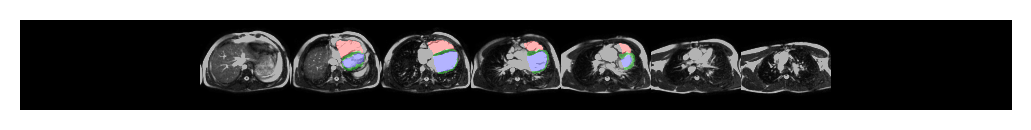

2020-12-07 14:37:08,605 INFO GT on AX


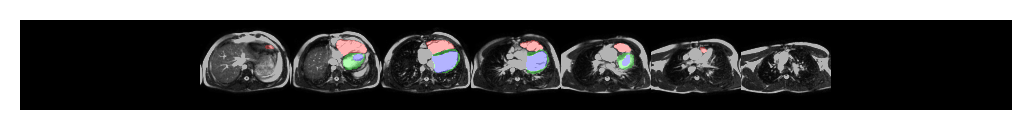

2020-12-07 14:37:09,111 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:37:09,119 INFO DICE LV: 0.9203422665596008
2020-12-07 14:37:09,127 INFO DICE RV: 0.821225106716156
2020-12-07 14:37:09,135 INFO DICE MYO: 0.6611449122428894
2020-12-07 14:37:09,202 INFO m: [[ 0.462  -0.71   -0.531  -0.9995]
 [ 0.3267 -0.42    0.846  -0.9976]
 [-0.824  -0.5645  0.0378 16.08  ]]
2020-12-07 14:37:09,203 INFO m_mod: [[ 0.462  -0.71   -0.531  -0.743 ]
 [ 0.3267 -0.42    0.846  -0.617 ]
 [-0.824  -0.5645  0.0378  1.329 ]]
2020-12-07 14:37:09,203 INFO m_scaled: [[ 0.462  -0.71   -0.531  -1.486 ]
 [ 0.3267 -0.42    0.846  -1.234 ]
 [-0.824  -0.5645  0.0378  2.658 ]]
2020-12-07 14:37:09,204 INFO 0000-5T8DXCQ2_2006-10-01_ES_msk.nrrd
2020-12-07 14:37:14,192 INFO DICE LV: 0.8645114302635193
2020-12-07 14:37:14,265 INFO DICE RV: 0.6924459338188171
2020-12-07 14:37:14,337 INFO DICE MYO: 0.6443588733673096
2020-12-07 14:37:14,889 INFO Predicted mask rotated to AX on original

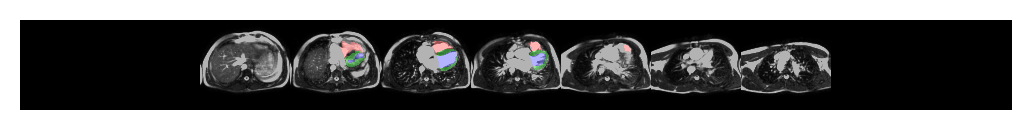

2020-12-07 14:37:15,326 INFO GT on AX


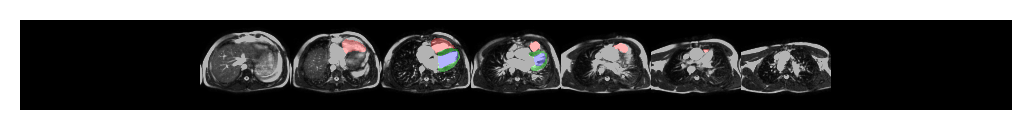

2020-12-07 14:37:15,832 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:37:15,840 INFO DICE LV: 0.8738202452659607
2020-12-07 14:37:15,848 INFO DICE RV: 0.6932533383369446
2020-12-07 14:37:15,856 INFO DICE MYO: 0.6453405618667603
2020-12-07 14:37:15,924 INFO m: [[ 0.4612  -0.704   -0.5405  -0.9995 ]
 [ 0.3274  -0.4312   0.841   -0.9976 ]
 [-0.8247  -0.5645   0.03174 16.19   ]]
2020-12-07 14:37:15,924 INFO m_mod: [[ 0.4612  -0.704   -0.5405  -0.7456 ]
 [ 0.3274  -0.4312   0.841   -0.6196 ]
 [-0.8247  -0.5645   0.03174  1.339  ]]
2020-12-07 14:37:15,925 INFO m_scaled: [[ 0.4612  -0.704   -0.5405  -1.491  ]
 [ 0.3274  -0.4312   0.841   -1.239  ]
 [-0.8247  -0.5645   0.03174  2.678  ]]
2020-12-07 14:37:15,926 INFO 0000-84R7FQH3_2007-03-16_ED_msk.nrrd
2020-12-07 14:37:20,895 INFO DICE LV: 0.9144642353057861
2020-12-07 14:37:20,968 INFO DICE RV: 0.8171513080596924
2020-12-07 14:37:21,042 INFO DICE MYO: 0.6182144284248352
2020-12-07 14:37:21,576 INFO Pre

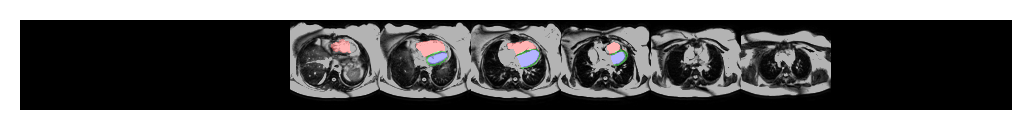

2020-12-07 14:37:22,007 INFO GT on AX


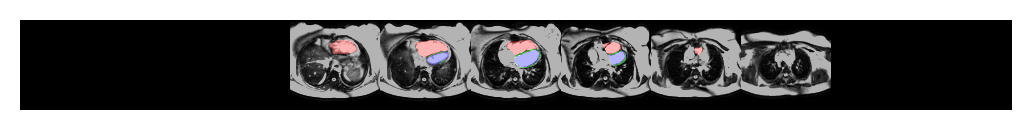

2020-12-07 14:37:22,500 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-07 14:37:22,507 INFO DICE LV: 0.922145426273346
2020-12-07 14:37:22,514 INFO DICE RV: 0.8332816958427429
2020-12-07 14:37:22,521 INFO DICE MYO: 0.6181378364562988
2020-12-07 14:37:22,589 INFO m: [[ 0.4688  -0.737   -0.487   -0.9995 ]
 [ 0.323   -0.37     0.871   -0.997  ]
 [-0.8223  -0.566    0.06464 15.53   ]]
2020-12-07 14:37:22,589 INFO m_mod: [[ 0.4688  -0.737   -0.487   -0.7314 ]
 [ 0.323   -0.37     0.871   -0.6045 ]
 [-0.8223  -0.566    0.06464  1.283  ]]
2020-12-07 14:37:22,590 INFO m_scaled: [[ 0.4688  -0.737   -0.487   -1.463  ]
 [ 0.323   -0.37     0.871   -1.209  ]
 [-0.8223  -0.566    0.06464  2.566  ]]
2020-12-07 14:37:22,590 INFO 0000-84R7FQH3_2007-03-16_ES_msk.nrrd
2020-12-07 14:37:27,542 INFO DICE LV: 0.8703981041908264
2020-12-07 14:37:27,615 INFO DICE RV: 0.8023923635482788
2020-12-07 14:37:27,688 INFO DICE MYO: 0.7366917729377747
2020-12-07 14:37:28,226 INFO Pred

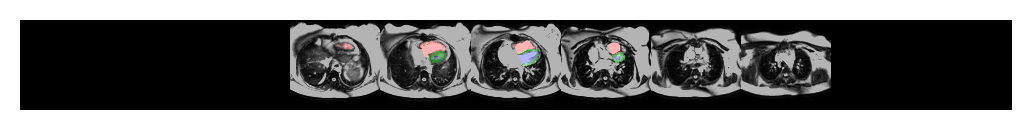

2020-12-07 14:37:28,656 INFO GT on AX


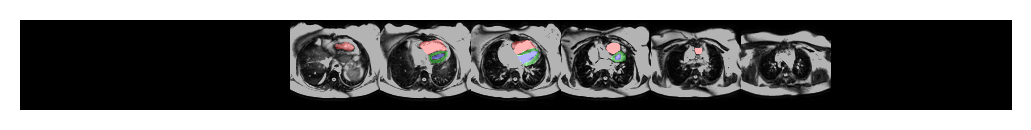

2020-12-07 14:37:29,148 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-07 14:37:29,156 INFO DICE LV: 0.8824942111968994
2020-12-07 14:37:29,164 INFO DICE RV: 0.8099011182785034
2020-12-07 14:37:29,171 INFO DICE MYO: 0.7453194260597229
2020-12-07 14:37:29,243 INFO m: [[ 0.466  -0.726  -0.5063 -0.9995]
 [ 0.3247 -0.3923  0.861  -0.997 ]
 [-0.823  -0.5654  0.0529 15.76  ]]
2020-12-07 14:37:29,244 INFO m_mod: [[ 0.466  -0.726  -0.5063 -0.7363]
 [ 0.3247 -0.3923  0.861  -0.61  ]
 [-0.823  -0.5654  0.0529  1.302 ]]
2020-12-07 14:37:29,244 INFO m_scaled: [[ 0.466  -0.726  -0.5063 -1.473 ]
 [ 0.3247 -0.3923  0.861  -1.22  ]
 [-0.823  -0.5654  0.0529  2.604 ]]
2020-12-07 14:37:29,245 INFO 0000-DG1U4JUW_2006-12-22_ED_msk.nrrd
2020-12-07 14:37:35,191 INFO DICE LV: 0.9338006973266602
2020-12-07 14:37:35,263 INFO DICE RV: 0.7669214010238647
2020-12-07 14:37:35,337 INFO DICE MYO: 0.699101984500885
2020-12-07 14:37:35,859 INFO Predicted mask rotated to AX on original

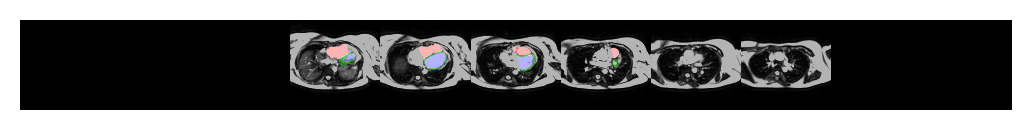

2020-12-07 14:37:36,286 INFO GT on AX


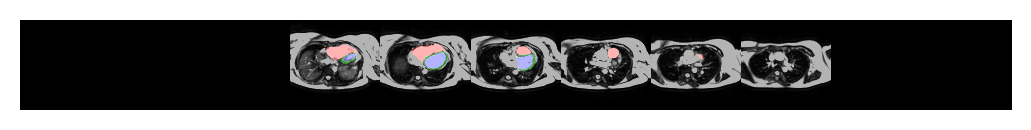

2020-12-07 14:37:36,790 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-07 14:37:36,798 INFO DICE LV: 0.9413153529167175
2020-12-07 14:37:36,805 INFO DICE RV: 0.7710441946983337
2020-12-07 14:37:36,812 INFO DICE MYO: 0.6996901631355286
2020-12-07 14:37:36,880 INFO m: [[ 0.463   -0.7124  -0.528   -0.9995 ]
 [ 0.3264  -0.4167   0.8486  -0.9976 ]
 [-0.824   -0.565    0.03952 16.03   ]]
2020-12-07 14:37:36,881 INFO m_mod: [[ 0.463   -0.7124  -0.528   -0.742  ]
 [ 0.3264  -0.4167   0.8486  -0.616  ]
 [-0.824   -0.565    0.03952  1.326  ]]
2020-12-07 14:37:36,881 INFO m_scaled: [[ 0.463   -0.7124  -0.528   -1.484  ]
 [ 0.3264  -0.4167   0.8486  -1.232  ]
 [-0.824   -0.565    0.03952  2.652  ]]
2020-12-07 14:37:36,882 INFO 0000-DG1U4JUW_2006-12-22_ES_msk.nrrd
2020-12-07 14:37:41,822 INFO DICE LV: 0.8550886511802673
2020-12-07 14:37:41,905 INFO DICE RV: 0.7369341850280762
2020-12-07 14:37:41,986 INFO DICE MYO: 0.7714929580688477
2020-12-07 14:37:42,527 INFO Pre

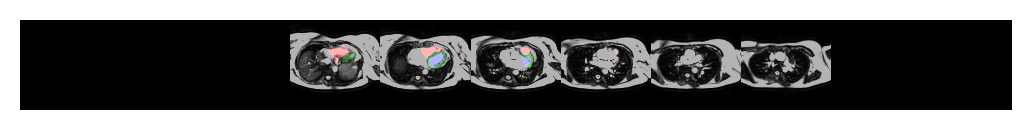

2020-12-07 14:37:42,960 INFO GT on AX


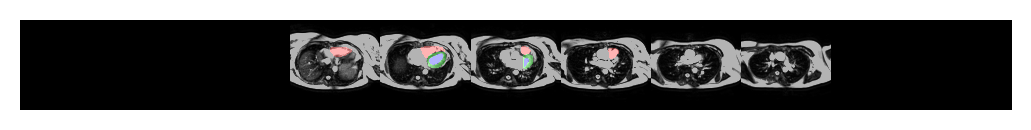

2020-12-07 14:37:43,439 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-07 14:37:43,447 INFO DICE LV: 0.8594467639923096
2020-12-07 14:37:43,455 INFO DICE RV: 0.741473913192749
2020-12-07 14:37:43,462 INFO DICE MYO: 0.7682332396507263
2020-12-07 14:37:43,530 INFO m: [[ 0.463   -0.713   -0.527   -0.9995 ]
 [ 0.3264  -0.416    0.849   -0.9976 ]
 [-0.824   -0.565    0.04007 16.03   ]]
2020-12-07 14:37:43,531 INFO m_mod: [[ 0.463   -0.713   -0.527   -0.742  ]
 [ 0.3264  -0.416    0.849   -0.616  ]
 [-0.824   -0.565    0.04007  1.325  ]]
2020-12-07 14:37:43,531 INFO m_scaled: [[ 0.463   -0.713   -0.527   -1.484  ]
 [ 0.3264  -0.416    0.849   -1.232  ]
 [-0.824   -0.565    0.04007  2.65   ]]
2020-12-07 14:37:43,532 INFO 0000-DHQPDW6M_2007-02-16_ED_msk.nrrd
2020-12-07 14:37:48,499 INFO DICE LV: 0.871091365814209
2020-12-07 14:37:48,594 INFO DICE RV: 0.7767717838287354
2020-12-07 14:37:48,690 INFO DICE MYO: 0.6711310744285583
2020-12-07 14:37:49,248 INFO Predi

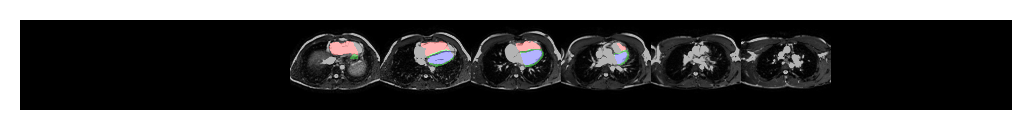

2020-12-07 14:37:49,681 INFO GT on AX


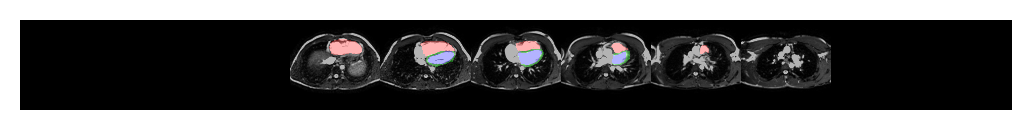

2020-12-07 14:37:50,229 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-07 14:37:50,237 INFO DICE LV: 0.8959936499595642
2020-12-07 14:37:50,244 INFO DICE RV: 0.7914572954177856
2020-12-07 14:37:50,251 INFO DICE MYO: 0.6817829012870789
2020-12-07 14:37:50,327 INFO m: [[ 4.551e-01 -6.753e-01 -5.806e-01 -9.995e-01]
 [ 3.306e-01 -4.768e-01  8.145e-01 -9.980e-01]
 [-8.267e-01 -5.625e-01  6.313e-03  1.669e+01]]
2020-12-07 14:37:50,328 INFO m_mod: [[ 0.455    -0.6753   -0.5806   -0.756   ]
 [ 0.3306   -0.4768    0.8145   -0.631   ]
 [-0.8267   -0.5625    0.006313  1.379   ]]
2020-12-07 14:37:50,328 INFO m_scaled: [[ 0.455    -0.6753   -0.5806   -1.512   ]
 [ 0.3306   -0.4768    0.8145   -1.262   ]
 [-0.8267   -0.5625    0.006313  2.758   ]]
2020-12-07 14:37:50,329 INFO 0000-DHQPDW6M_2007-02-16_ES_msk.nrrd
2020-12-07 14:37:55,342 INFO DICE LV: 0.8261587023735046
2020-12-07 14:37:55,430 INFO DICE RV: 0.6269809603691101
2020-12-07 14:37:55,512 INFO DICE MYO: 0.7

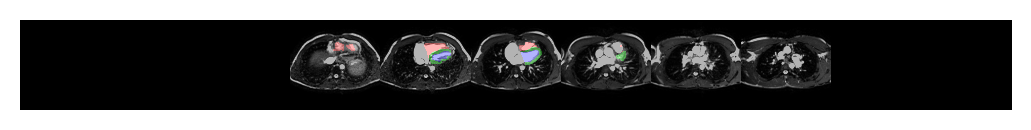

2020-12-07 14:37:56,510 INFO GT on AX


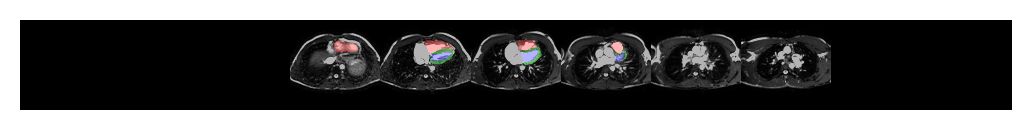

2020-12-07 14:37:57,017 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-07 14:37:57,024 INFO DICE LV: 0.8638885617256165
2020-12-07 14:37:57,031 INFO DICE RV: 0.643818199634552
2020-12-07 14:37:57,037 INFO DICE MYO: 0.7306442856788635
2020-12-07 14:37:57,114 INFO m: [[ 4.541e-01 -6.660e-01 -5.923e-01 -9.995e-01]
 [ 3.323e-01 -4.907e-01  8.062e-01 -9.980e-01]
 [-8.271e-01 -5.625e-01 -1.375e-03  1.683e+01]]
2020-12-07 14:37:57,115 INFO m_mod: [[ 4.541e-01 -6.660e-01 -5.923e-01 -7.588e-01]
 [ 3.323e-01 -4.907e-01  8.062e-01 -6.338e-01]
 [-8.271e-01 -5.625e-01 -1.375e-03  1.392e+00]]
2020-12-07 14:37:57,115 INFO m_scaled: [[ 4.541e-01 -6.660e-01 -5.923e-01 -1.518e+00]
 [ 3.323e-01 -4.907e-01  8.062e-01 -1.268e+00]
 [-8.271e-01 -5.625e-01 -1.375e-03  2.783e+00]]
2020-12-07 14:37:57,116 INFO 0000-E4YTNGAZ_2006-11-07_ED_msk.nrrd
2020-12-07 14:38:03,073 INFO DICE LV: 0.9294067025184631
2020-12-07 14:38:03,169 INFO DICE RV: 0.8056540489196777
2020-12-07 14:38:03

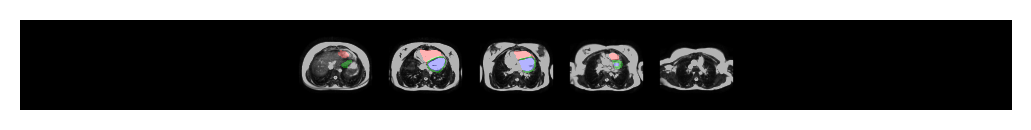

2020-12-07 14:38:04,236 INFO GT on AX


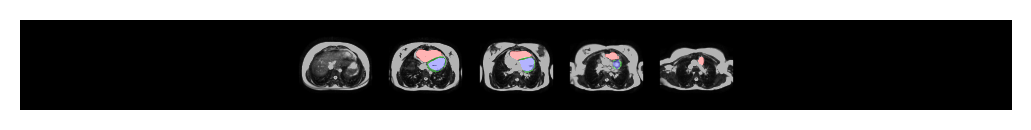

2020-12-07 14:38:04,709 INFO inv mask shape: (18, 288, 288, 4), gt mask shape: (18, 288, 288, 4)
2020-12-07 14:38:04,716 INFO DICE LV: 0.9356683492660522
2020-12-07 14:38:04,724 INFO DICE RV: 0.8058480024337769
2020-12-07 14:38:04,731 INFO DICE MYO: 0.6540511846542358
2020-12-07 14:38:04,816 INFO m: [[ 4.519e-01 -6.553e-01 -6.055e-01 -9.995e-01]
 [ 3.333e-01 -5.054e-01  7.959e-01 -9.980e-01]
 [-8.276e-01 -5.615e-01 -1.015e-02  1.700e+01]]
2020-12-07 14:38:04,817 INFO m_mod: [[ 0.452   -0.6553  -0.6055  -0.7627 ]
 [ 0.3333  -0.5054   0.796   -0.6377 ]
 [-0.8276  -0.5615  -0.01015  1.406  ]]
2020-12-07 14:38:04,817 INFO m_scaled: [[ 0.452   -0.6553  -0.6055  -1.525  ]
 [ 0.3333  -0.5054   0.796   -1.275  ]
 [-0.8276  -0.5615  -0.01015  2.812  ]]
2020-12-07 14:38:04,818 INFO 0000-E4YTNGAZ_2006-11-07_ES_msk.nrrd
2020-12-07 14:38:10,798 INFO DICE LV: 0.8948882222175598
2020-12-07 14:38:10,892 INFO DICE RV: 0.7779793739318848
2020-12-07 14:38:10,987 INFO DICE MYO: 0.7365304827690125
2020-12-

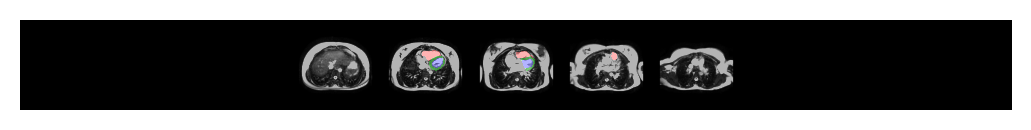

2020-12-07 14:38:11,967 INFO GT on AX


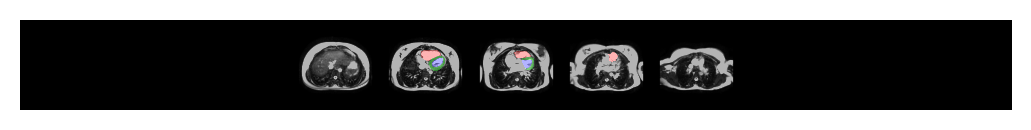

2020-12-07 14:38:12,436 INFO inv mask shape: (18, 288, 288, 4), gt mask shape: (18, 288, 288, 4)
2020-12-07 14:38:12,443 INFO DICE LV: 0.8921970129013062
2020-12-07 14:38:12,451 INFO DICE RV: 0.7893074154853821
2020-12-07 14:38:12,458 INFO DICE MYO: 0.7349266409873962
2020-12-07 14:38:12,541 INFO m: [[ 4.512e-01 -6.523e-01 -6.094e-01 -9.995e-01]
 [ 3.337e-01 -5.098e-01  7.935e-01 -9.980e-01]
 [-8.276e-01 -5.610e-01 -1.233e-02  1.705e+01]]
2020-12-07 14:38:12,542 INFO m_mod: [[ 0.4512  -0.6523  -0.6094  -0.7637 ]
 [ 0.3337  -0.51     0.7935  -0.6387 ]
 [-0.8276  -0.561   -0.01233  1.409  ]]
2020-12-07 14:38:12,542 INFO m_scaled: [[ 0.4512  -0.6523  -0.6094  -1.527  ]
 [ 0.3337  -0.51     0.7935  -1.277  ]
 [-0.8276  -0.561   -0.01233  2.818  ]]
2020-12-07 14:38:12,543 INFO 0000-ER5Q2EXD_2007-02-22_ED_msk.nrrd
2020-12-07 14:38:17,515 INFO DICE LV: 0.8724991083145142
2020-12-07 14:38:17,611 INFO DICE RV: 0.6909033060073853
2020-12-07 14:38:17,705 INFO DICE MYO: 0.5221207737922668
2020-12-

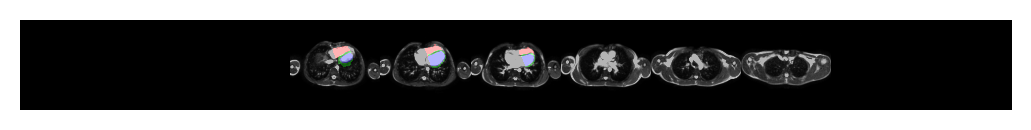

2020-12-07 14:38:18,702 INFO GT on AX


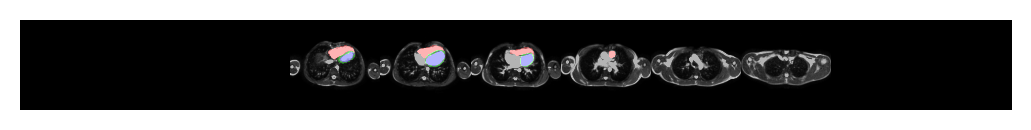

2020-12-07 14:38:19,273 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:38:19,281 INFO DICE LV: 0.8784763216972351
2020-12-07 14:38:19,289 INFO DICE RV: 0.6680458188056946
2020-12-07 14:38:19,296 INFO DICE MYO: 0.5239796042442322
2020-12-07 14:38:19,381 INFO m: [[ 0.4482 -0.632  -0.633  -0.9995]
 [ 0.336  -0.537   0.7734 -0.9985]
 [-0.8286 -0.559  -0.0287 17.38  ]]
2020-12-07 14:38:19,382 INFO m_mod: [[ 0.4482 -0.632  -0.633  -0.7695]
 [ 0.336  -0.537   0.7734 -0.6455]
 [-0.8286 -0.559  -0.0287  1.437 ]]
2020-12-07 14:38:19,382 INFO m_scaled: [[ 0.4482 -0.632  -0.633  -1.539 ]
 [ 0.336  -0.537   0.7734 -1.291 ]
 [-0.8286 -0.559  -0.0287  2.873 ]]
2020-12-07 14:38:19,383 INFO 0000-ER5Q2EXD_2007-02-22_ES_msk.nrrd
2020-12-07 14:38:24,418 INFO DICE LV: 0.8479808568954468
2020-12-07 14:38:24,515 INFO DICE RV: 0.5592066049575806
2020-12-07 14:38:24,603 INFO DICE MYO: 0.647294819355011
2020-12-07 14:38:25,143 INFO Predicted mask rotated to AX on original

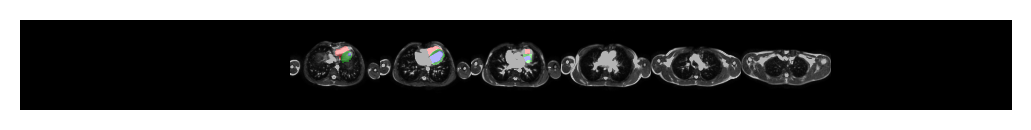

2020-12-07 14:38:25,592 INFO GT on AX


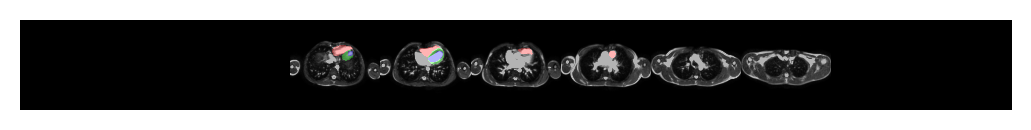

2020-12-07 14:38:26,163 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:38:26,172 INFO DICE LV: 0.8585688471794128
2020-12-07 14:38:26,180 INFO DICE RV: 0.5534374713897705
2020-12-07 14:38:26,188 INFO DICE MYO: 0.6636481285095215
2020-12-07 14:38:26,273 INFO m: [[ 0.447   -0.624   -0.6406  -0.9995 ]
 [ 0.3367  -0.5464   0.767   -0.9985 ]
 [-0.8286  -0.5586  -0.03415 17.47   ]]
2020-12-07 14:38:26,273 INFO m_mod: [[ 0.447   -0.624   -0.6406  -0.7715 ]
 [ 0.3367  -0.5464   0.767   -0.6475 ]
 [-0.8286  -0.5586  -0.03415  1.444  ]]
2020-12-07 14:38:26,274 INFO m_scaled: [[ 0.447   -0.624   -0.6406  -1.543  ]
 [ 0.3367  -0.5464   0.767   -1.295  ]
 [-0.8286  -0.5586  -0.03415  2.889  ]]
2020-12-07 14:38:26,275 INFO 0000-F0QP6ZJR_2006-01-01_ED_msk.nrrd
2020-12-07 14:38:31,312 INFO DICE LV: 0.8961739540100098
2020-12-07 14:38:31,408 INFO DICE RV: 0.6516567468643188
2020-12-07 14:38:31,496 INFO DICE MYO: 0.7140546441078186
2020-12-07 14:38:32,052 INFO Pre

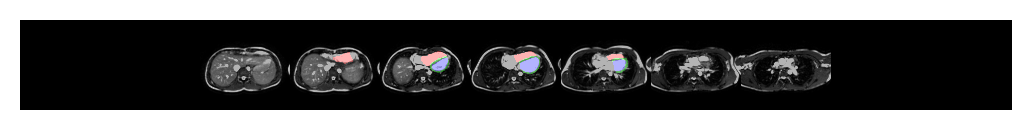

2020-12-07 14:38:32,489 INFO GT on AX


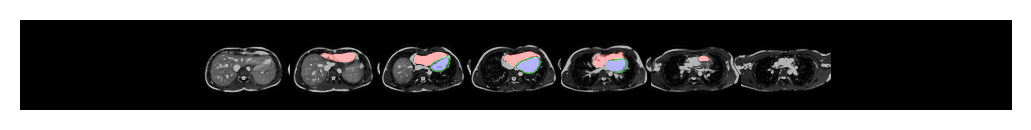

2020-12-07 14:38:33,058 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:38:33,066 INFO DICE LV: 0.9047187566757202
2020-12-07 14:38:33,074 INFO DICE RV: 0.6647911667823792
2020-12-07 14:38:33,082 INFO DICE MYO: 0.720321536064148
2020-12-07 14:38:33,169 INFO m: [[ 4.524e-01 -6.592e-01 -6.016e-01 -9.995e-01]
 [ 3.328e-01 -5.015e-01  7.993e-01 -9.980e-01]
 [-8.276e-01 -5.615e-01 -7.408e-03  1.695e+01]]
2020-12-07 14:38:33,169 INFO m_mod: [[ 0.4524  -0.659   -0.6016  -0.761  ]
 [ 0.3328  -0.5015   0.7993  -0.6367 ]
 [-0.8276  -0.5615  -0.00741  1.401  ]]
2020-12-07 14:38:33,170 INFO m_scaled: [[ 0.4524  -0.659   -0.6016  -1.522  ]
 [ 0.3328  -0.5015   0.7993  -1.273  ]
 [-0.8276  -0.5615  -0.00741  2.803  ]]
2020-12-07 14:38:33,171 INFO 0000-F0QP6ZJR_2006-01-01_ES_msk.nrrd
2020-12-07 14:38:38,240 INFO DICE LV: 0.8683089017868042
2020-12-07 14:38:38,335 INFO DICE RV: 0.6323661208152771
2020-12-07 14:38:38,423 INFO DICE MYO: 0.7686142325401306
2020-12-0

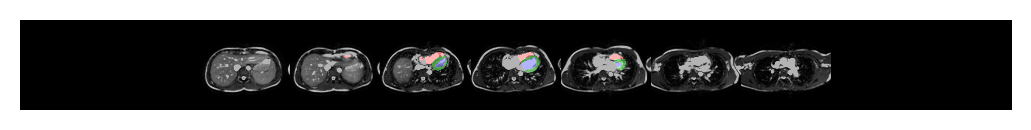

2020-12-07 14:38:39,400 INFO GT on AX


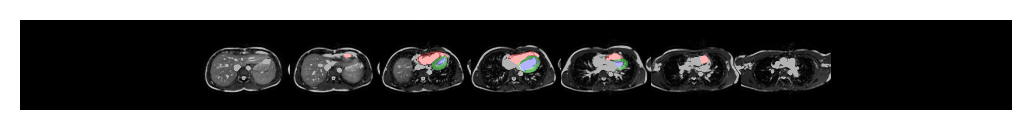

2020-12-07 14:38:39,971 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-07 14:38:39,979 INFO DICE LV: 0.8736478686332703
2020-12-07 14:38:39,987 INFO DICE RV: 0.6359942555427551
2020-12-07 14:38:39,995 INFO DICE MYO: 0.766547441482544
2020-12-07 14:38:40,082 INFO m: [[ 4.509e-01 -6.494e-01 -6.118e-01 -9.995e-01]
 [ 3.337e-01 -5.127e-01  7.905e-01 -9.980e-01]
 [-8.276e-01 -5.605e-01 -1.452e-02  1.708e+01]]
2020-12-07 14:38:40,083 INFO m_mod: [[ 0.451   -0.6494  -0.612   -0.7637 ]
 [ 0.3337  -0.5127   0.7905  -0.639  ]
 [-0.8276  -0.5605  -0.01452  1.412  ]]
2020-12-07 14:38:40,083 INFO m_scaled: [[ 0.451   -0.6494  -0.612   -1.527  ]
 [ 0.3337  -0.5127   0.7905  -1.278  ]
 [-0.8276  -0.5605  -0.01452  2.824  ]]
2020-12-07 14:38:40,084 INFO 0000-JERK6VC0_2006-01-19_ED_msk.nrrd
2020-12-07 14:38:45,110 INFO DICE LV: 0.6351252794265747
2020-12-07 14:38:45,199 INFO DICE RV: 0.7268186211585999
2020-12-07 14:38:45,288 INFO DICE MYO: 0.41794872283935547
2020-12-

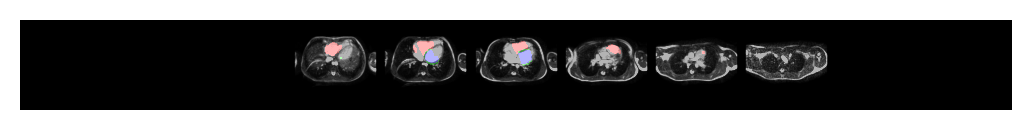

2020-12-07 14:38:46,282 INFO GT on AX


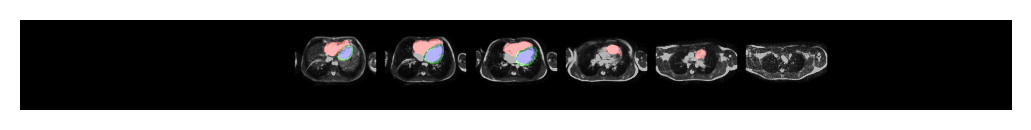

2020-12-07 14:38:46,797 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-07 14:38:46,804 INFO DICE LV: 0.6450111865997314
2020-12-07 14:38:46,811 INFO DICE RV: 0.7447899580001831
2020-12-07 14:38:46,818 INFO DICE MYO: 0.4442797601222992
2020-12-07 14:38:46,905 INFO m: [[ 0.4492  -0.642   -0.6206  -0.9995 ]
 [ 0.3342  -0.5234   0.7837  -0.9985 ]
 [-0.828   -0.5596  -0.02051 17.2    ]]
2020-12-07 14:38:46,906 INFO m_mod: [[ 0.4492  -0.642   -0.6206  -0.7666 ]
 [ 0.3342  -0.5234   0.7837  -0.6416 ]
 [-0.828   -0.5596  -0.02051  1.423  ]]
2020-12-07 14:38:46,906 INFO m_scaled: [[ 0.4492  -0.642   -0.6206  -1.533  ]
 [ 0.3342  -0.5234   0.7837  -1.283  ]
 [-0.828   -0.5596  -0.02051  2.846  ]]
2020-12-07 14:38:46,907 INFO 0000-JERK6VC0_2006-01-19_ES_msk.nrrd
2020-12-07 14:38:51,950 INFO DICE LV: 0.5991193056106567
2020-12-07 14:38:52,038 INFO DICE RV: 0.6176382303237915
2020-12-07 14:38:52,125 INFO DICE MYO: 0.40498924255371094
2020-12-07 14:38:52,694 INFO Pr

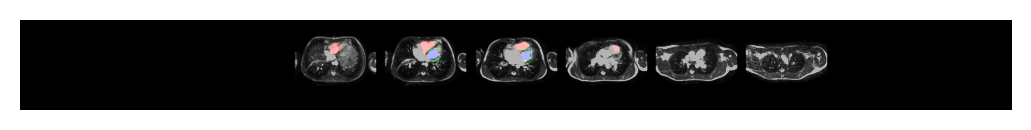

2020-12-07 14:38:53,125 INFO GT on AX


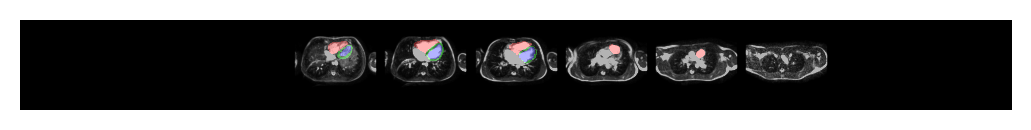

2020-12-07 14:38:53,602 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-07 14:38:53,609 INFO DICE LV: 0.6338198184967041
2020-12-07 14:38:53,616 INFO DICE RV: 0.6816582679748535
2020-12-07 14:38:53,623 INFO DICE MYO: 0.4304722845554352
2020-12-07 14:38:53,706 INFO m: [[ 0.449  -0.639  -0.624  -0.9995]
 [ 0.3347 -0.527   0.781  -0.9985]
 [-0.828  -0.5596 -0.0227 17.23  ]]
2020-12-07 14:38:53,707 INFO m_mod: [[ 0.449  -0.639  -0.624  -0.7676]
 [ 0.3347 -0.527   0.781  -0.6426]
 [-0.828  -0.5596 -0.0227  1.426 ]]
2020-12-07 14:38:53,707 INFO m_scaled: [[ 0.449  -0.639  -0.624  -1.535 ]
 [ 0.3347 -0.527   0.781  -1.285 ]
 [-0.828  -0.5596 -0.0227  2.852 ]]
2020-12-07 14:38:53,708 INFO 0000-K5T17122_2005-08-25_ED_msk.nrrd
2020-12-07 14:38:58,743 INFO DICE LV: 0.7936084270477295
2020-12-07 14:38:58,833 INFO DICE RV: 0.4590284526348114
2020-12-07 14:38:58,922 INFO DICE MYO: 0.4885788559913635
2020-12-07 14:38:59,483 INFO Predicted mask rotated to AX on origina

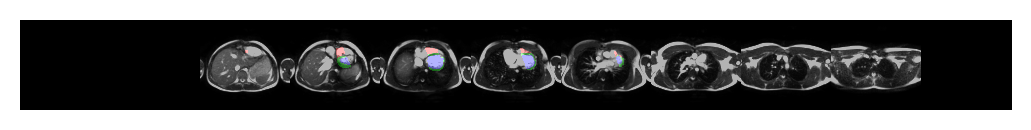

2020-12-07 14:38:59,920 INFO GT on AX


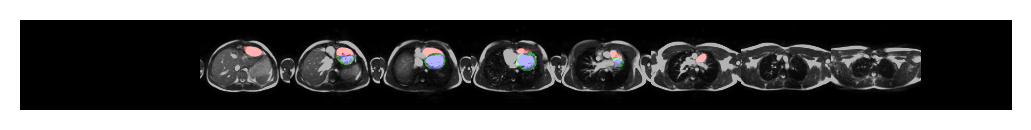

2020-12-07 14:39:00,526 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-07 14:39:00,534 INFO DICE LV: 0.8110513091087341
2020-12-07 14:39:00,541 INFO DICE RV: 0.4508949816226959
2020-12-07 14:39:00,548 INFO DICE MYO: 0.5192041397094727
2020-12-07 14:39:00,632 INFO m: [[ 4.556e-01 -6.768e-01 -5.781e-01 -9.995e-01]
 [ 3.308e-01 -4.739e-01  8.159e-01 -9.980e-01]
 [-8.262e-01 -5.630e-01  7.965e-03  1.664e+01]]
2020-12-07 14:39:00,633 INFO m_mod: [[ 0.4556   -0.677    -0.578    -0.755   ]
 [ 0.3308   -0.4739    0.816    -0.63    ]
 [-0.826    -0.563     0.007965  1.375   ]]
2020-12-07 14:39:00,633 INFO m_scaled: [[ 0.4556   -0.677    -0.578    -1.51    ]
 [ 0.3308   -0.4739    0.816    -1.26    ]
 [-0.826    -0.563     0.007965  2.75    ]]
2020-12-07 14:39:00,634 INFO 0000-K5T17122_2005-08-25_ES_msk.nrrd
2020-12-07 14:39:05,680 INFO DICE LV: 0.6384740471839905
2020-12-07 14:39:05,782 INFO DICE RV: 0.2778351306915283
2020-12-07 14:39:05,879 INFO DICE MYO: 0.5

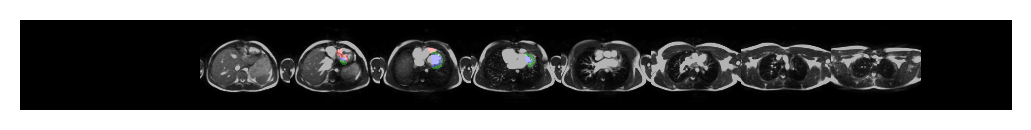

2020-12-07 14:39:06,928 INFO GT on AX


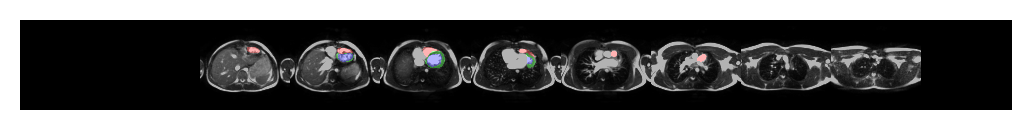

2020-12-07 14:39:07,522 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-07 14:39:07,530 INFO DICE LV: 0.6598575711250305
2020-12-07 14:39:07,536 INFO DICE RV: 0.2294606864452362
2020-12-07 14:39:07,543 INFO DICE MYO: 0.5492812991142273
2020-12-07 14:39:07,634 INFO m: [[ 4.556e-01 -6.748e-01 -5.806e-01 -9.995e-01]
 [ 3.311e-01 -4.766e-01  8.145e-01 -9.980e-01]
 [-8.262e-01 -5.630e-01  6.317e-03  1.667e+01]]
2020-12-07 14:39:07,634 INFO m_mod: [[ 0.4556   -0.675    -0.5806   -0.756   ]
 [ 0.331    -0.4766    0.8145   -0.6304  ]
 [-0.826    -0.563     0.006317  1.378   ]]
2020-12-07 14:39:07,635 INFO m_scaled: [[ 0.4556   -0.675    -0.5806   -1.512   ]
 [ 0.331    -0.4766    0.8145   -1.261   ]
 [-0.826    -0.563     0.006317  2.756   ]]
2020-12-07 14:39:07,636 INFO 0000-KHQNN842_2006-01-01_ED_msk.nrrd
2020-12-07 14:39:12,677 INFO DICE LV: 0.9062095880508423
2020-12-07 14:39:12,773 INFO DICE RV: 0.820000171661377
2020-12-07 14:39:12,874 INFO DICE MYO: 0.58

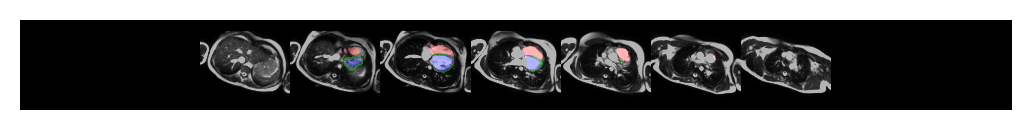

2020-12-07 14:39:13,870 INFO GT on AX


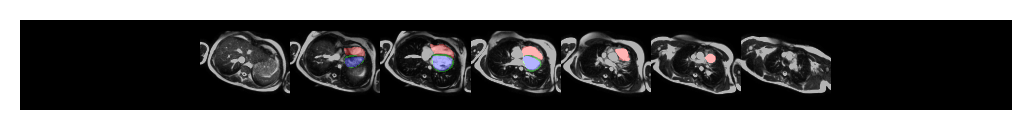

2020-12-07 14:39:14,438 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-07 14:39:14,446 INFO DICE LV: 0.9179360270500183
2020-12-07 14:39:14,454 INFO DICE RV: 0.8160486221313477
2020-12-07 14:39:14,461 INFO DICE MYO: 0.5922792553901672
2020-12-07 14:39:14,547 INFO m: [[ 0.462  -0.709  -0.532  -0.9995]
 [ 0.3267 -0.4219  0.8457 -0.9976]
 [-0.824  -0.565   0.0367 16.1   ]]
2020-12-07 14:39:14,548 INFO m_mod: [[ 0.462  -0.709  -0.532  -0.7437]
 [ 0.3267 -0.4219  0.8457 -0.6177]
 [-0.824  -0.565   0.0367  1.331 ]]
2020-12-07 14:39:14,548 INFO m_scaled: [[ 0.462  -0.709  -0.532  -1.487 ]
 [ 0.3267 -0.4219  0.8457 -1.235 ]
 [-0.824  -0.565   0.0367  2.662 ]]
2020-12-07 14:39:14,549 INFO 0000-KHQNN842_2006-01-01_ES_msk.nrrd
2020-12-07 14:39:19,615 INFO DICE LV: 0.8610098958015442
2020-12-07 14:39:19,711 INFO DICE RV: 0.7775629758834839
2020-12-07 14:39:19,798 INFO DICE MYO: 0.7145885825157166
2020-12-07 14:39:20,345 INFO Predicted mask rotated to AX on origina

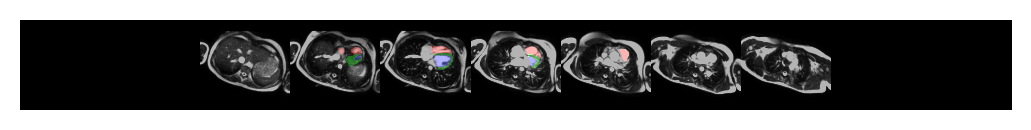

2020-12-07 14:39:20,782 INFO GT on AX


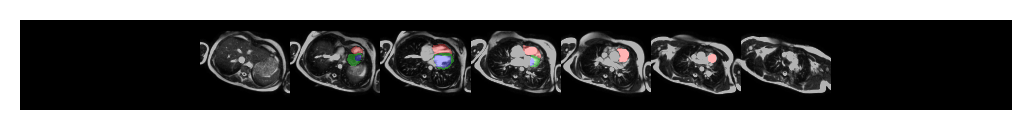

2020-12-07 14:39:21,354 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-07 14:39:21,362 INFO DICE LV: 0.8699614405632019
2020-12-07 14:39:21,368 INFO DICE RV: 0.7766605019569397
2020-12-07 14:39:21,376 INFO DICE MYO: 0.7321495413780212
2020-12-07 14:39:21,462 INFO m: [[ 0.4626  -0.7114  -0.529   -0.9995 ]
 [ 0.3267  -0.418    0.8477  -0.9976 ]
 [-0.824   -0.565    0.03897 16.05   ]]
2020-12-07 14:39:21,463 INFO m_mod: [[ 0.4626  -0.7114  -0.529   -0.7427 ]
 [ 0.3267  -0.418    0.8477  -0.616  ]
 [-0.824   -0.565    0.03897  1.327  ]]
2020-12-07 14:39:21,463 INFO m_scaled: [[ 0.4626  -0.7114  -0.529   -1.485  ]
 [ 0.3267  -0.418    0.8477  -1.232  ]
 [-0.824   -0.565    0.03897  2.654  ]]
2020-12-07 14:39:21,464 INFO 0000-LLLNJLF6_2006-09-27_ED_msk.nrrd
2020-12-07 14:39:26,524 INFO DICE LV: 0.7936921715736389
2020-12-07 14:39:26,618 INFO DICE RV: 0.7392143607139587
2020-12-07 14:39:26,705 INFO DICE MYO: 0.4007907509803772
2020-12-07 14:39:27,290 INFO Pre

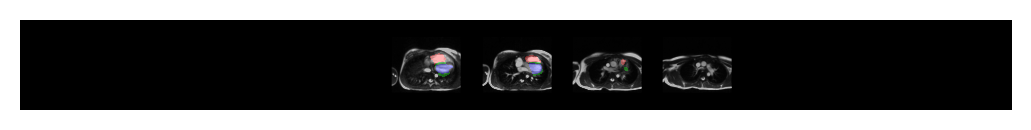

2020-12-07 14:39:27,719 INFO GT on AX


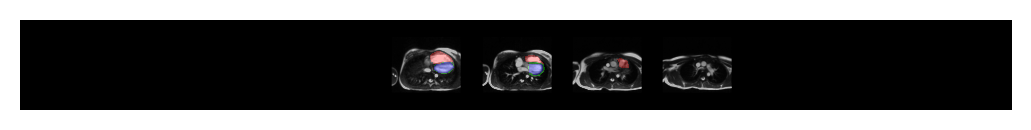

2020-12-07 14:39:28,153 INFO inv mask shape: (15, 156, 192, 4), gt mask shape: (15, 156, 192, 4)
2020-12-07 14:39:28,156 INFO DICE LV: 0.8225268125534058
2020-12-07 14:39:28,159 INFO DICE RV: 0.7560619711875916
2020-12-07 14:39:28,162 INFO DICE MYO: 0.40896064043045044
2020-12-07 14:39:28,248 INFO m: [[ 0.4438  -0.6025  -0.6636  -1.     ]
 [ 0.3384  -0.5728   0.747   -0.9985 ]
 [-0.8296  -0.556   -0.05035 17.8    ]]
2020-12-07 14:39:28,249 INFO m_mod: [[ 0.4438  -0.6025  -0.6636  -0.778  ]
 [ 0.3384  -0.5728   0.747   -0.6543 ]
 [-0.8296  -0.556   -0.05035  1.472  ]]
2020-12-07 14:39:28,250 INFO m_scaled: [[ 0.4438  -0.6025  -0.6636  -1.556  ]
 [ 0.3384  -0.5728   0.747   -1.309  ]
 [-0.8296  -0.556   -0.05035  2.943  ]]
2020-12-07 14:39:28,250 INFO 0000-LLLNJLF6_2006-09-27_ES_msk.nrrd
2020-12-07 14:39:33,244 INFO DICE LV: 0.7424510717391968
2020-12-07 14:39:33,332 INFO DICE RV: 0.7208490967750549
2020-12-07 14:39:33,418 INFO DICE MYO: 0.4583792984485626
2020-12-07 14:39:33,963 INFO Pr

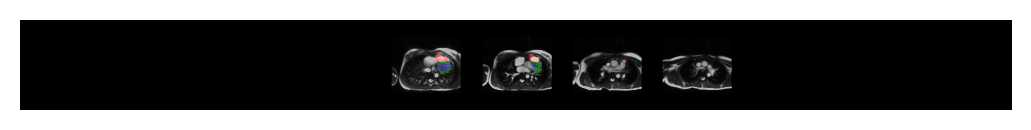

2020-12-07 14:39:34,388 INFO GT on AX


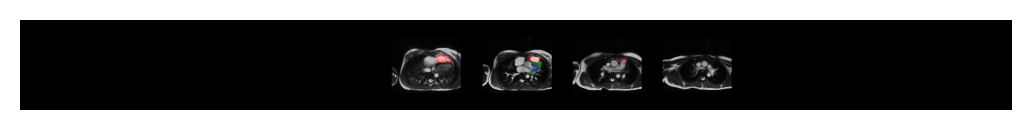

2020-12-07 14:39:34,820 INFO inv mask shape: (15, 156, 192, 4), gt mask shape: (15, 156, 192, 4)
2020-12-07 14:39:34,823 INFO DICE LV: 0.7748618721961975
2020-12-07 14:39:34,826 INFO DICE RV: 0.7225274443626404
2020-12-07 14:39:34,828 INFO DICE MYO: 0.43878886103630066
2020-12-07 14:39:34,911 INFO m: [[ 0.4456  -0.617   -0.649   -0.9995 ]
 [ 0.337   -0.556    0.7603  -0.9985 ]
 [-0.8296  -0.557   -0.04007 17.6    ]]
2020-12-07 14:39:34,911 INFO m_mod: [[ 0.4456  -0.617   -0.649   -0.774  ]
 [ 0.337   -0.556    0.7603  -0.65   ]
 [-0.8296  -0.557   -0.04007  1.455  ]]
2020-12-07 14:39:34,912 INFO m_scaled: [[ 0.4456  -0.617   -0.649   -1.548  ]
 [ 0.337   -0.556    0.7603  -1.3    ]
 [-0.8296  -0.557   -0.04007  2.91   ]]
2020-12-07 14:39:34,913 INFO 0000-LV70LENY_2007-03-12_ED_msk.nrrd
2020-12-07 14:39:43,856 INFO DICE LV: 0.8897981643676758
2020-12-07 14:39:43,931 INFO DICE RV: 0.8087635636329651
2020-12-07 14:39:44,004 INFO DICE MYO: 0.6719721555709839
2020-12-07 14:39:44,542 INFO Pr

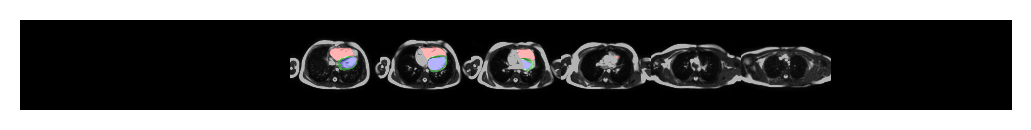

2020-12-07 14:39:44,978 INFO GT on AX


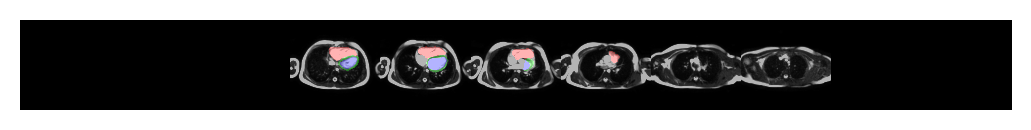

2020-12-07 14:39:45,471 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-07 14:39:45,479 INFO DICE LV: 0.8950913548469543
2020-12-07 14:39:45,487 INFO DICE RV: 0.7921938300132751
2020-12-07 14:39:45,494 INFO DICE MYO: 0.6590787172317505
2020-12-07 14:39:45,565 INFO m: [[ 4.543e-01 -6.699e-01 -5.869e-01 -9.995e-01]
 [ 3.315e-01 -4.846e-01  8.091e-01 -9.980e-01]
 [-8.271e-01 -5.625e-01  1.921e-03  1.677e+01]]
2020-12-07 14:39:45,566 INFO m_mod: [[ 0.4543   -0.67     -0.587    -0.758   ]
 [ 0.3315   -0.4846    0.809    -0.633   ]
 [-0.827    -0.5625    0.001921  1.388   ]]
2020-12-07 14:39:45,566 INFO m_scaled: [[ 4.543e-01 -6.699e-01 -5.869e-01 -1.516e+00]
 [ 3.315e-01 -4.846e-01  8.091e-01 -1.266e+00]
 [-8.271e-01 -5.625e-01  1.921e-03  2.775e+00]]
2020-12-07 14:39:45,567 INFO 0000-LV70LENY_2007-03-12_ES_msk.nrrd
2020-12-07 14:39:50,774 INFO DICE LV: 0.8270394802093506
2020-12-07 14:39:50,848 INFO DICE RV: 0.7952684164047241
2020-12-07 14:39:50,924 INFO D

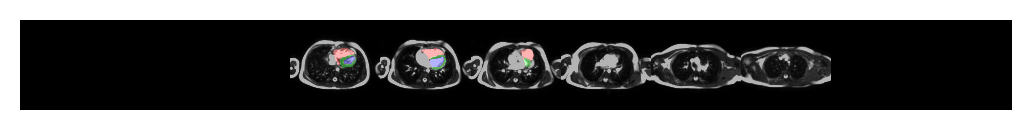

2020-12-07 14:39:51,889 INFO GT on AX


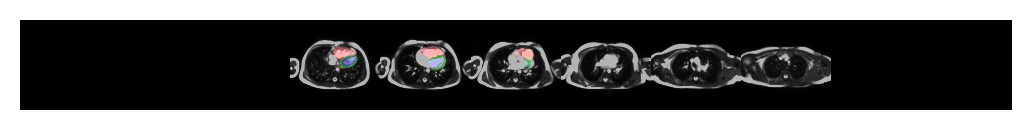

2020-12-07 14:39:52,400 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-07 14:39:52,407 INFO DICE LV: 0.8298917412757874
2020-12-07 14:39:52,414 INFO DICE RV: 0.8098036646842957
2020-12-07 14:39:52,420 INFO DICE MYO: 0.732559084892273
2020-12-07 14:39:52,488 INFO m: [[ 4.546e-01 -6.714e-01 -5.854e-01 -9.995e-01]
 [ 3.313e-01 -4.824e-01  8.105e-01 -9.980e-01]
 [-8.267e-01 -5.625e-01  3.019e-03  1.675e+01]]
2020-12-07 14:39:52,489 INFO m_mod: [[ 0.4546  -0.6714  -0.5854  -0.7573 ]
 [ 0.3313  -0.4824   0.8105  -0.632  ]
 [-0.8267  -0.5625   0.00302  1.386  ]]
2020-12-07 14:39:52,489 INFO m_scaled: [[ 0.4546  -0.6714  -0.5854  -1.515  ]
 [ 0.3313  -0.4824   0.8105  -1.264  ]
 [-0.8267  -0.5625   0.00302  2.771  ]]
2020-12-07 14:39:52,490 INFO 0000-MA4HVCMK_2006-06-22_ED_msk.nrrd
2020-12-07 14:39:58,631 INFO DICE LV: 0.9134891033172607
2020-12-07 14:39:58,705 INFO DICE RV: 0.7860177159309387
2020-12-07 14:39:58,779 INFO DICE MYO: 0.6866811513900757
2020-12-0

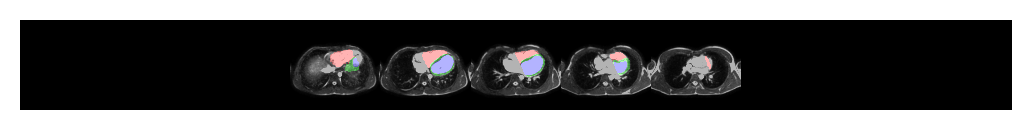

2020-12-07 14:39:59,759 INFO GT on AX


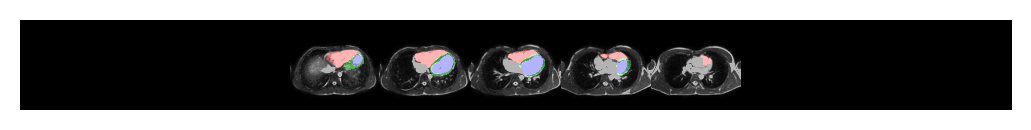

2020-12-07 14:40:00,249 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-07 14:40:00,256 INFO DICE LV: 0.9250543713569641
2020-12-07 14:40:00,262 INFO DICE RV: 0.8067742586135864
2020-12-07 14:40:00,267 INFO DICE MYO: 0.694889485836029
2020-12-07 14:40:00,335 INFO m: [[ 0.4497  -0.6426  -0.62    -0.9995 ]
 [ 0.3345  -0.5225   0.784   -0.9985 ]
 [-0.828   -0.56    -0.01997 17.2    ]]
2020-12-07 14:40:00,336 INFO m_mod: [[ 0.4497  -0.6426  -0.62    -0.7666 ]
 [ 0.3345  -0.5225   0.784   -0.6416 ]
 [-0.828   -0.56    -0.01997  1.423  ]]
2020-12-07 14:40:00,336 INFO m_scaled: [[ 0.4497  -0.6426  -0.62    -1.533  ]
 [ 0.3345  -0.5225   0.784   -1.283  ]
 [-0.828   -0.56    -0.01997  2.846  ]]
2020-12-07 14:40:00,337 INFO 0000-MA4HVCMK_2006-06-22_ES_msk.nrrd
2020-12-07 14:40:05,366 INFO DICE LV: 0.8511508107185364
2020-12-07 14:40:05,441 INFO DICE RV: 0.7111209034919739
2020-12-07 14:40:05,514 INFO DICE MYO: 0.699591875076294
2020-12-07 14:40:06,051 INFO Predi

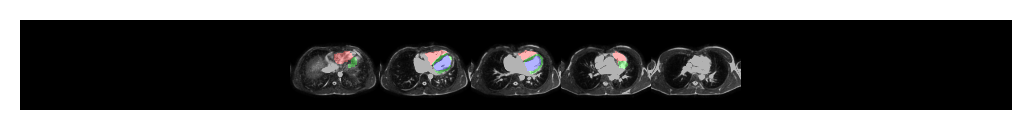

2020-12-07 14:40:06,488 INFO GT on AX


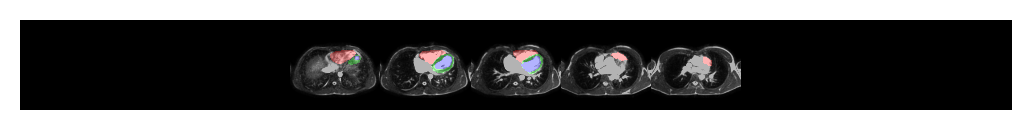

2020-12-07 14:40:06,976 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-07 14:40:06,983 INFO DICE LV: 0.862328290939331
2020-12-07 14:40:06,988 INFO DICE RV: 0.7271679639816284
2020-12-07 14:40:06,994 INFO DICE MYO: 0.7016985416412354
2020-12-07 14:40:07,062 INFO m: [[ 0.447   -0.624   -0.6406  -0.9995 ]
 [ 0.3367  -0.5464   0.767   -0.9985 ]
 [-0.8286  -0.5586  -0.03415 17.47   ]]
2020-12-07 14:40:07,062 INFO m_mod: [[ 0.447   -0.624   -0.6406  -0.7715 ]
 [ 0.3367  -0.5464   0.767   -0.6475 ]
 [-0.8286  -0.5586  -0.03415  1.445  ]]
2020-12-07 14:40:07,063 INFO m_scaled: [[ 0.447   -0.624   -0.6406  -1.543  ]
 [ 0.3367  -0.5464   0.767   -1.295  ]
 [-0.8286  -0.5586  -0.03415  2.89   ]]


In [16]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False
experiment_identifier = 'tests_80_112_112_sp3_10ax_10sax_1focus_thres08_inpl_f3'

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
path_1 = 'data/predicted/{}/3D/'.format(experiment_identifier)
path_2 = path_1.replace('_post', '_NoPost')

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=False, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)

# Further tests, where do our model fail, do we over- or under-segment

In [26]:
print(gt.shape)
print(pred.shape)
print(ax2sax.shape)

(160, 224, 224, 3)
(160, 224, 224, 4)
(1, 160, 224, 224, 1)


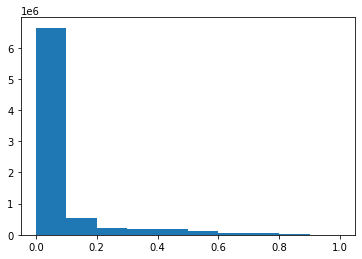

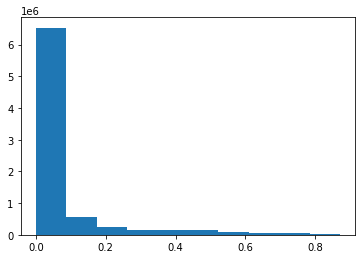

In [32]:
from src.data.Preprocess import clip_quantile
temp = ax2sax[0]
temp_a = clip_quantile(temp, .999)
#show_2D_or_3D(temp)
plt.hist(temp.flatten())
plt.show()
plt.hist(temp_a.flatten())
plt.show()

In [33]:
temp_pred = unet_model.predict(x=[ax2sax])
temp_a_pred = unet_model.predict(x=[temp_a[np.newaxis,...]])

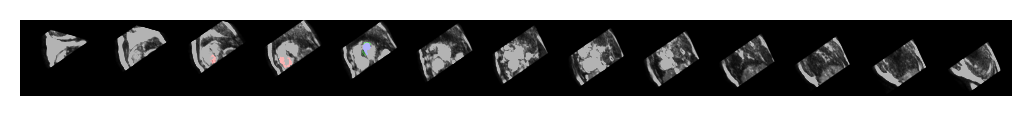

In [39]:
show_2D_or_3D(temp, temp_pred[0])
plt.show()

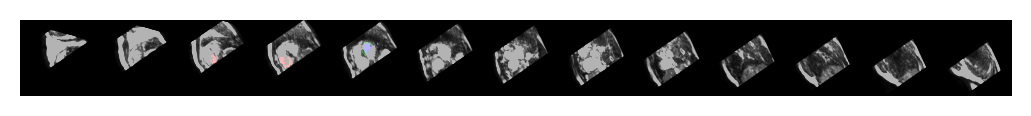

In [40]:
show_2D_or_3D(temp_a, temp_a_pred[0])
plt.show()

In [31]:
temp2.shape

(1, 160, 224, 224, 3)

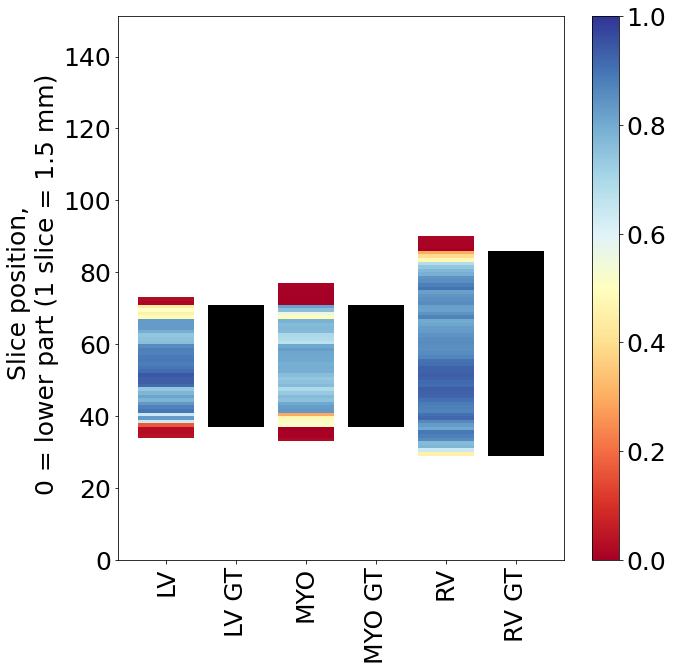

In [22]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)

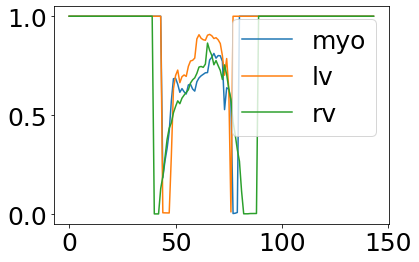

In [31]:
# Create a lineplot for the errors within the volume
plot_dice_per_slice_line(gt,pred)

# Temp tests

In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
